# Section 1: Robust Ensemble Damage Classification with Feature Engineering, SMOTE, and Threshold Optimization
In this section, we develop and rigorously optimize a 3-class building damage classifier for the Gaza Strip using advanced ensemble learning methods. We address extreme class imbalance with SMOTE oversampling, automatically select and engineer the most informative remote sensing and urban features, and combine state-of-the-art LightGBM, XGBoost, and CatBoost models into a robust, GPU-accelerated ensemble. Model outputs are further calibrated and per-class decision thresholds are tuned to maximize practical F1-scores across all damage levels. We conclude with interpretability analysis using SHAP values to highlight the key features driving model decisions.

In [ ]:
#@title 1. Setup and Imports
# INSTALL REQUIRED PACKAGES
!pip install geopandas shapely folium matplotlib scikit-learn xgboost optuna --quiet

# IMPORT LIBRARIES
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import json
from shapely.geometry import Point, Polygon
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, classification_report
from sklearn.preprocessing import LabelEncoder, StandardScaler
from xgboost import XGBRegressor, XGBClassifier

# Optional: For hyperparameter tuning
import optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.0/247.0 kB 21.1 MB/s eta 0:00:00


In [ ]:
#@title 2. Load Data from Google Drive
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# File path
file_path = '/content/drive/MyDrive/damage_features_buildings_updated.gpkg'

# Load GPKG using GeoPandas
import geopandas as gpd

# Read the geopackage
gdf = gpd.read_file(file_path)

# Preview the data
print(f"Total records: {len(gdf)}")
gdf.head()

Mounted at /content/drive
Total records: 335498


,id,addr:city,building,layer,zone,name,name:ar,name:en,shop,amenity,...,opt_post_band2_mean,opt_post_band3_mean,opt_post_band4_mean,opt_post_band5_mean,opt_post_band6_mean,opt_post_band7_mean,opt_post_band8_mean,sar_pre_band1_mean,sar_post_band1_mean,geometry
0,29684904,Rafah,yes,1,Z1,None,None,None,None,None,...,1802.6633165829146,2255.3781407035176,2315.9497487437184,2996.255025125628,2822.358040201005,2871.3391959798996,3102.316582914573,-2.056103,-2.126184,"POLYGON ((619470.716 3457596.219, 619564.507 3..."
1,29684943,Rafah,yes,None,Z1,None,None,None,None,None,...,2322.5348837209303,2910.3333333333335,3047.8372093023254,3742.3720930232557,3466.8992248062013,3592.3798449612405,3793.2093023255816,-2.103449,-1.779312,"POLYGON ((619427.604 3457710.687, 619469.65 34..."
2,29727198,None,yes,None,Z1,None,None,None,None,None,...,1645.7222222222222,1792.9259259259259,2066.3703703703704,2274.1666666666665,2310.240740740741,2497.324074074074,2753.962962962963,-1.730658,-0.650285,"POLYGON ((619276.773 3461785.05, 619287.826 34..."
3,41312804,None,yes,None,Z1,مركز رفح التجاري,مركز رفح التجاري,Rafah Trade Center,None,None,...,1509.3072289156626,1633.6927710843374,1897.6385542168675,2083.1927710843374,2149.4457831325303,2292.0,2523.234939759036,-1.648076,-2.307026,"POLYGON ((619272.064 3461579.357, 619293.235 3..."
4,41312981,None,yes,None,Z1,Balbula,ورشة بلبولة لتصليح السيارات,None,car_repair,None,...,1339.0602409638554,1444.7469879518073,1684.120481927711,1858.5301204819277,1901.2289156626507,2028.5060240963855,2326.9156626506024,-2.533896,0.022403,"POLYGON ((619835.186 3461756.71, 619860.415 34..."


In [ ]:
#@title 3. Data Cleaning and Initial Feature Engineering

# Filter out rows without geometries
gdf = gdf[gdf.geometry.notnull()].copy()

# Drop columns with >90% missing values
threshold = 0.9
null_ratio = gdf.isnull().mean()
gdf = gdf.drop(columns=null_ratio[null_ratio > threshold].index)

# Show remaining columns
print(f"Remaining columns after filtering: {len(gdf.columns)}")
print("Sample columns:", gdf.columns[:20].tolist())

# Identify available numerical features
possible_numerical = [
    'Grouped_Damage_Classes_mean',
    'Main_Damage_Site_Class_mean',
    'Damage_Status_2_mean',
    'building:levels',
    'height',
    'area',
    'PERIMETER',
    'LAND_DUN'
]
numerical_cols = [col for col in possible_numerical if col in gdf.columns]

# Identify optical and SAR band columns
spectral_cols = [col for col in gdf.columns if 'opt_' in col or 'sar_' in col]

# Ensure all spectral columns are numeric (convert non-numeric entries to NaN)
for col in spectral_cols:
    gdf[col] = pd.to_numeric(gdf[col], errors='coerce')

# Add spectral columns to numerical list
numerical_cols += spectral_cols

# Identify available categorical features
possible_categorical = ['building', 'amenity', 'shop', 'construction']
categorical_cols = [col for col in possible_categorical if col in gdf.columns]

# Fill missing values
gdf[numerical_cols] = gdf[numerical_cols].fillna(0)
for col in categorical_cols:
    gdf[col] = gdf[col].fillna("unknown")

# Encode categorical columns
from sklearn.preprocessing import LabelEncoder
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    gdf[col] = le.fit_transform(gdf[col])
    label_encoders[col] = le

# Final set of features to be used in modeling
available_features = categorical_cols + spectral_cols
print(f"Total features available for ML: {len(available_features)}")


Remaining columns after filtering: 215
Sample columns: ['id', 'building', 'zone', 'source', 'path', 'Grouped_Damage_Classes_count', 'Grouped_Damage_Classes_unique', 'Grouped_Damage_Classes_min', 'Grouped_Damage_Classes_max', 'Grouped_Damage_Classes_range', 'Grouped_Damage_Classes_sum', 'Grouped_Damage_Classes_mean', 'Grouped_Damage_Classes_median', 'Grouped_Damage_Classes_stddev', 'Grouped_Damage_Classes_minority', 'Grouped_Damage_Classes_majority', 'Grouped_Damage_Classes_q1', 'Grouped_Damage_Classes_q3', 'Grouped_Damage_Classes_iqr', 'Main_Damage_Site_Class_count']
Total features available for ML: 19


In [ ]:
#@title 4. Define Target + Features, Train-Test Split (Multi-Class Ready)

# Use the updated damage class column
target_class_col = 'Main_Damage_Site_Class_3_majority'

# Filter and create a copy to avoid SettingWithCopyWarning
gdf = gdf[gdf[target_class_col].notnull()].copy()
gdf[target_class_col] = pd.to_numeric(gdf[target_class_col], errors='coerce').astype(int)

# Define features and target
X = gdf[available_features].copy()
y = gdf[target_class_col]

# Drop any rows with missing feature values
X = X.dropna()
y = y.loc[X.index]  # Align target with valid feature rows

# Perform a stratified train-test split to preserve class distribution
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Print class distribution
print("Class distribution in training set:")
print(y_train.value_counts().sort_index())
print("\nClass distribution in test set:")
print(y_test.value_counts().sort_index())

Class distribution in training set:
Main_Damage_Site_Class_3_majority
1     5690
2     4825
3    14151
4     8310
5        7
Name: count, dtype: int64

Class distribution in test set:
Main_Damage_Site_Class_3_majority
1    1423
2    1206
3    3538
4    2077
5       2
Name: count, dtype: int64


Fitting 3 folds for each of 10 candidates, totalling 30 fits


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [17:57:20] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best Parameters Found: {'subsample': 0.8, 'n_estimators': 200, 'max_depth': 8, 'learning_rate': 0.1, 'colsample_bytree': 0.8}

Classification Report (Original Class Labels):
              precision    recall  f1-score   support

           1     0.4605    0.4877    0.4737      1423
           2     0.2304    0.1899    0.2082      1206
           3     0.5205    0.5020    0.5111      3538
           4     0.3969    0.4454    0.4198      2079

    accuracy                         0.4396      8246
   macro avg     0.4021    0.4062    0.4032      8246
weighted avg     0.4366    0.4396    0.4373      8246

Confusion Matrix (Original Class Labels):
[[ 694  168  383  178]
 [ 234  229  467  276]
 [ 386  423 1776  953]
 [ 193  174  786  926]]


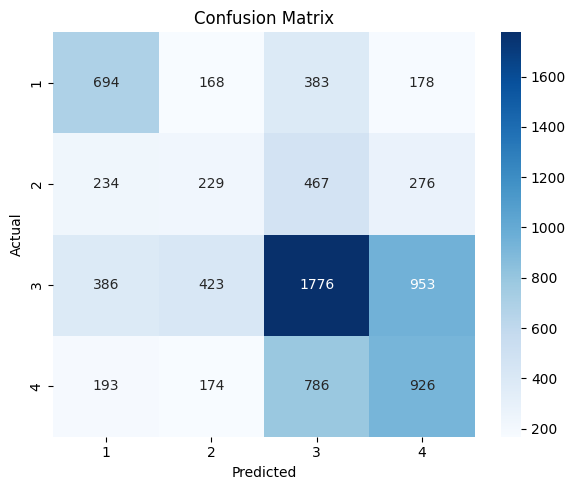

In [ ]:
#@title 5. Train and Evaluate XGBoost Classifier (With All Enhancements)

from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# === A. FEATURE ENGINEERING ===

# 1. Delta features (pre/post optical & SAR)
for band in range(1, 9):
    gdf[f'opt_delta_band{band}'] = gdf[f'opt_post_band{band}_mean'] - gdf[f'opt_pre_band{band}_mean']

# 2. SAR delta
gdf['sar_delta_band1'] = gdf['sar_post_band1_mean'] - gdf['sar_pre_band1_mean']

# 3. NDVI features
gdf["ndvi_pre"] = (gdf["opt_pre_band8_mean"] - gdf["opt_pre_band4_mean"]) / (gdf["opt_pre_band8_mean"] + gdf["opt_pre_band4_mean"] + 1e-5)
gdf["ndvi_post"] = (gdf["opt_post_band8_mean"] - gdf["opt_post_band4_mean"]) / (gdf["opt_post_band8_mean"] + gdf["opt_post_band4_mean"] + 1e-5)
gdf["ndvi_delta"] = gdf["ndvi_post"] - gdf["ndvi_pre"]

# === B. TARGET + FEATURE SELECTION ===

# Merge class 5 into class 4 to reduce sparsity
y_train = y_train.replace(5, 4)
y_test = y_test.replace(5, 4)

# Identify full set of engineered features
feature_cols = [col for col in gdf.columns if
                any(substr in col for substr in ['opt_', 'sar_', 'delta', 'ndvi']) or
                col in ['building']]

X_train = gdf.loc[y_train.index, feature_cols]
X_test = gdf.loc[y_test.index, feature_cols]

# Ensure numeric types
X_train = X_train.apply(pd.to_numeric, errors='coerce').fillna(0)
X_test = X_test.apply(pd.to_numeric, errors='coerce').fillna(0)

# Encode target labels
unique_classes = sorted(y_train.unique())
class_mapping = {orig: new for new, orig in enumerate(unique_classes)}
inverse_mapping = {v: k for k, v in class_mapping.items()}
y_train_mapped = y_train.map(class_mapping)
y_test_mapped = y_test.map(class_mapping)

# === C. CLASS BALANCING ===

# Compute balanced sample weights
weights = compute_class_weight(class_weight='balanced',
                                classes=np.array(list(class_mapping.values())),
                                y=y_train_mapped)
class_weights_dict = dict(zip(class_mapping.values(), weights))
sample_weights = y_train_mapped.map(class_weights_dict)

# === D. OPTIONAL: SMOTE OVERSAMPLING (TOGGLE) ===
apply_smote = False
if apply_smote:
    sm = SMOTE(random_state=42)
    X_train, y_train_mapped = sm.fit_resample(X_train, y_train_mapped)
    sample_weights = None  # SMOTE balances classes

# === E. HYPERPARAMETER SEARCH WITH XGBOOST ===

param_dist = {
    'n_estimators': [100, 150, 200],
    'max_depth': [4, 6, 8],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

base_clf = XGBClassifier(
    objective='multi:softmax',
    num_class=len(class_mapping),
    random_state=42,
    eval_metric='mlogloss',
    use_label_encoder=False
)

grid = RandomizedSearchCV(
    estimator=base_clf,
    param_distributions=param_dist,
    n_iter=10,
    scoring='accuracy',
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

grid.fit(X_train, y_train_mapped, sample_weight=sample_weights)

clf = grid.best_estimator_

# === F. EVALUATION ===

# Predict and reverse-map
y_pred_mapped = clf.predict(X_test)
y_pred = pd.Series(y_pred_mapped).map(inverse_mapping)

print("Best Parameters Found:", grid.best_params_)
print("\nClassification Report (Original Class Labels):")
print(classification_report(y_test, y_pred, digits=4))

print("Confusion Matrix (Original Class Labels):")
print(confusion_matrix(y_test, y_pred, labels=unique_classes))

# Plot Confusion Matrix
cm = confusion_matrix(y_test, y_pred, labels=unique_classes)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=unique_classes, yticklabels=unique_classes)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002903 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7670
[LightGBM] [Info] Number of data points in the train set: 32983, number of used features: 31
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with p

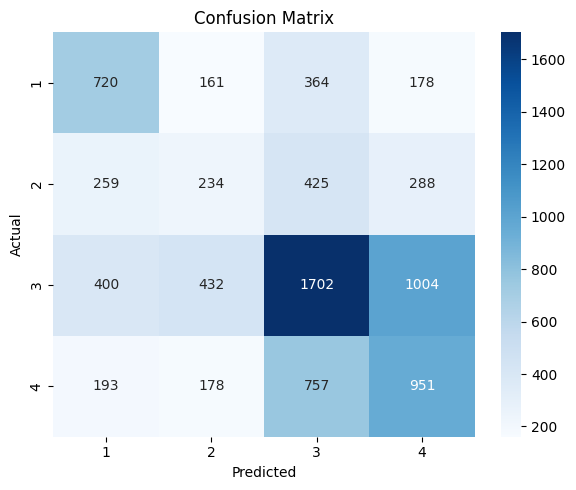

In [ ]:
#@title 6. Train and Evaluate Enhanced XGBoost Classifier with Probabilities and Ensemble

from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Optional toggles
apply_smote = False  # Set to True to apply SMOTE oversampling
use_ensemble = True  # Set to True to average predictions with LightGBM

# 1: Merge sparse class 5 into class 4
y_train = y_train.replace(5, 4)
y_test = y_test.replace(5, 4)

# 2: Map class labels to 0-indexed integers
unique_classes = sorted(y_train.unique())
class_mapping = {orig: new for new, orig in enumerate(unique_classes)}
inverse_mapping = {v: k for k, v in class_mapping.items()}

y_train_mapped = y_train.map(class_mapping)
y_test_mapped = y_test.map(class_mapping)

# 3: Compute class weights
weights = compute_class_weight(class_weight='balanced', classes=np.array(list(class_mapping.values())), y=y_train_mapped)
class_weights_dict = dict(zip(class_mapping.values(), weights))
sample_weights = y_train_mapped.map(class_weights_dict)

# 4: Optional SMOTE oversampling
if apply_smote:
    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train_mapped)
    sample_weights_resampled = compute_class_weight('balanced', classes=np.unique(y_train_resampled), y=y_train_resampled)
    sample_weights = np.array([sample_weights_resampled[label] for label in y_train_resampled])
    y_train_input = y_train_resampled
    X_train_input = X_train_resampled
else:
    y_train_input = y_train_mapped
    X_train_input = X_train

# 5: XGBoost model with probability output
xgb_model = XGBClassifier(
    objective='multi:softprob',
    num_class=len(class_mapping),
    max_depth=8,
    learning_rate=0.1,
    n_estimators=200,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    tree_method='hist'
)
xgb_model.fit(X_train_input, y_train_input, sample_weight=sample_weights)

# 6: LightGBM ensemble model (optional)
if use_ensemble:
    lgb_model = lgb.LGBMClassifier(
        objective='multiclass',
        num_class=len(class_mapping),
        max_depth=8,
        learning_rate=0.1,
        n_estimators=200,
        class_weight='balanced',
        random_state=42
    )
    lgb_model.fit(X_train, y_train_mapped)

# 7: Predict class probabilities
probs_xgb = xgb_model.predict_proba(X_test)

if use_ensemble:
    probs_lgb = lgb_model.predict_proba(X_test)
    avg_probs = (probs_xgb + probs_lgb) / 2
else:
    avg_probs = probs_xgb

# 8: Final prediction by argmax of averaged probabilities
y_pred_mapped = np.argmax(avg_probs, axis=1)
y_pred = pd.Series(y_pred_mapped).map(inverse_mapping)

# 9: Evaluation
print("Classification Report (Original Class Labels):")
print(classification_report(y_test, y_pred, digits=4))

print("Confusion Matrix (Original Class Labels):")
cm = confusion_matrix(y_test, y_pred, labels=unique_classes)
print(cm)

# 10: Confusion Matrix Plot
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=unique_classes, yticklabels=unique_classes)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Classification Report (Original Class Labels):
              precision    recall  f1-score   support

           1     0.4230    0.5039    0.4599      1423
           2     0.1996    0.2985    0.2392      1206
           3     0.5112    0.2908    0.3707      3538
           4     0.3753    0.4935    0.4263      2079

    accuracy                         0.3798      8246
   macro avg     0.3773    0.3967    0.3741      8246
weighted avg     0.4161    0.3798    0.3809      8246

Confusion Matrix (Original Class Labels):
[[ 717  304  219  183]
 [ 274  360  288  284]
 [ 492  776 1029 1241]
 [ 212  364  477 1026]]


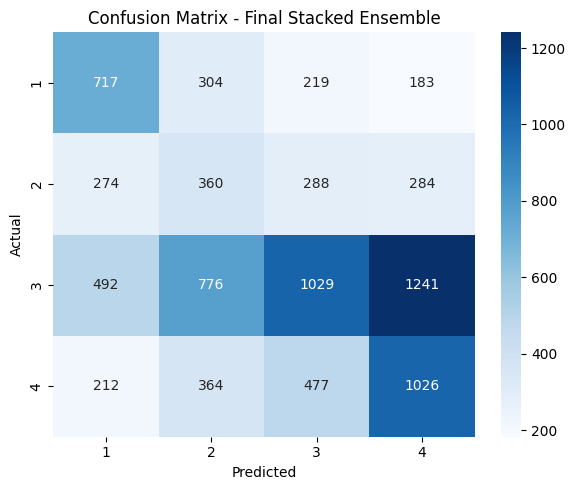

In [ ]:
#@title 7. Train Robust Stacked Ensemble with SMOTE, Scaling, and Optimized Meta-Learner

from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# 1. Merge sparse class 5 into 4
y_train = y_train.replace(5, 4)
y_test = y_test.replace(5, 4)

# 2. Map class labels to 0-indexed integers
unique_classes = sorted(y_train.unique())
class_mapping = {orig: new for new, orig in enumerate(unique_classes)}
inverse_mapping = {v: k for k, v in class_mapping.items()}

y_train_mapped = y_train.map(class_mapping)
y_test_mapped = y_test.map(class_mapping)

# 3. Feature selection using XGBoost
xgb_fs = XGBClassifier(n_estimators=100, random_state=42)
xgb_fs.fit(X_train, y_train_mapped)
selector = SelectFromModel(xgb_fs, prefit=True, threshold="median")
X_train_sel = selector.transform(X_train)
X_test_sel = selector.transform(X_test)

# 4. Apply SMOTE for balancing classes
sm = SMOTE(random_state=42)
X_train_bal, y_train_bal = sm.fit_resample(X_train_sel, y_train_mapped)

# 5. Scale features for meta-learner
scaler = StandardScaler()
X_train_bal_scaled = scaler.fit_transform(X_train_bal)
X_test_scaled = scaler.transform(X_test_sel)

# 6. Base models
xgb = XGBClassifier(
    n_estimators=150, max_depth=6, learning_rate=0.1,
    subsample=0.8, colsample_bytree=0.8, random_state=42,
    objective='multi:softprob', use_label_encoder=False, eval_metric='mlogloss'
)

lgb = LGBMClassifier(
    n_estimators=150, max_depth=6, learning_rate=0.1,
    subsample=0.8, colsample_bytree=0.8, random_state=42
)

rf = RandomForestClassifier(n_estimators=100, max_depth=6, class_weight='balanced', random_state=42)

# 7. Meta-learner: RandomForest (robust to imbalance)
meta = RandomForestClassifier(n_estimators=100, max_depth=4, random_state=42)

# 8. Stacking classifier
stacked_clf = StackingClassifier(
    estimators=[('xgb', xgb), ('lgb', lgb), ('rf', rf)],
    final_estimator=meta,
    cv=3,
    passthrough=True,
    n_jobs=-1
)

# 9. Train stacked model
stacked_clf.fit(X_train_bal_scaled, y_train_bal)

# 10. Predict
y_pred = stacked_clf.predict(X_test_scaled)
y_pred_orig = pd.Series(y_pred).map(inverse_mapping)

# 11. Evaluate
print("Classification Report (Original Class Labels):")
print(classification_report(y_test, y_pred_orig, digits=4))

print("Confusion Matrix (Original Class Labels):")
cm = confusion_matrix(y_test, y_pred_orig, labels=unique_classes)
print(cm)

# 12. Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=unique_classes, yticklabels=unique_classes)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Final Stacked Ensemble")
plt.tight_layout()
plt.show()


Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 200, 'subsample': 0.8}
Classification Report (Original Class Labels):
              precision    recall  f1-score   support

           1     0.4350    0.5032    0.4666      1423
           2     0.2163    0.2131    0.2147      1206
           3     0.5285    0.4293    0.4738      3538
           4     0.3775    0.4608    0.4150      2079

    accuracy                         0.4184      8246
   macro avg     0.3893    0.4016    0.3925      8246
weighted avg     0.4286    0.4184    0.4198      8246

Confusion Matrix:
[[ 716  207  313  187]
 [ 284  257  365  300]
 [ 447  479 1519 1093]
 [ 199  245  677  958]]


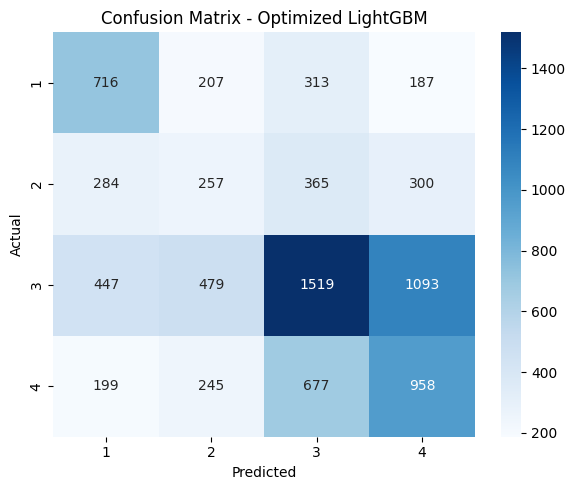

In [ ]:
#@title Final Model: LightGBM with Balanced Class Weights and GridSearch

from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# 1. Merge class 5 into 4
y_train = y_train.replace(5, 4)
y_test = y_test.replace(5, 4)

# 2. Encode classes
unique_classes = sorted(y_train.unique())
class_mapping = {orig: new for new, orig in enumerate(unique_classes)}
inverse_mapping = {v: k for k, v in class_mapping.items()}

y_train_mapped = y_train.map(class_mapping)
y_test_mapped = y_test.map(class_mapping)

# 3. Train LightGBM with class_weight balanced
param_grid = {
    'learning_rate': [0.1],
    'max_depth': [8],
    'n_estimators': [200],
    'subsample': [0.8],
    'colsample_bytree': [0.8]
}

lgb_model = LGBMClassifier(objective='multiclass',
                           class_weight='balanced',
                           random_state=42,
                           verbosity=-1)

grid = GridSearchCV(estimator=lgb_model, param_grid=param_grid,
                    scoring='accuracy', cv=3, verbose=1, n_jobs=-1)

grid.fit(X_train, y_train_mapped)

print("Best Parameters:", grid.best_params_)

# 4. Predict and decode
y_pred_mapped = grid.predict(X_test)
y_pred = pd.Series(y_pred_mapped).map(inverse_mapping)

# 5. Evaluation
print("Classification Report (Original Class Labels):")
print(classification_report(y_test, y_pred, digits=4))

cm = confusion_matrix(y_test, y_pred, labels=unique_classes)
print("Confusion Matrix:")
print(cm)

# 6. Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=unique_classes, yticklabels=unique_classes)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Optimized LightGBM")
plt.tight_layout()
plt.show()


Applying SMOTE to balance class distribution...
Fitting 3 folds for each of 2 candidates, totalling 6 fits
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7694
[LightGBM] [Info] Number of data points in the train set: 56604, number of used features: 31
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (1.73 MB) transferred to GPU in 0.002299 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 150, 's

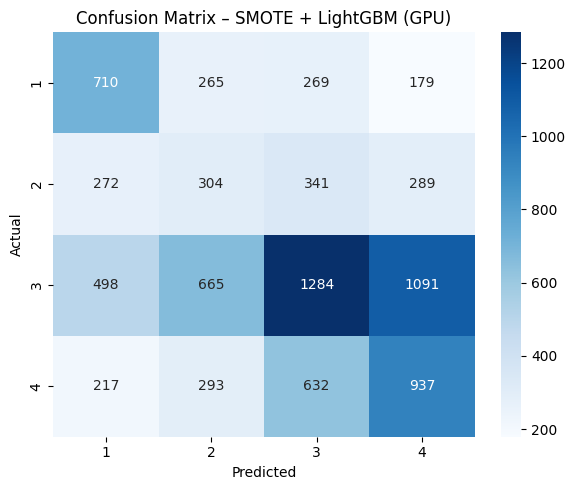

In [ ]:
#@title SMOTE + LightGBM (GPU) + GridSearchCV

from imblearn.over_sampling import SMOTE
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# 1. Merge class 5 → 4
y_train = y_train.replace(5, 4)
y_test = y_test.replace(5, 4)

# 2. Encode classes
unique_classes = sorted(y_train.unique())
class_mapping = {label: idx for idx, label in enumerate(unique_classes)}
inverse_mapping = {v: k for k, v in class_mapping.items()}
y_train_mapped = y_train.map(class_mapping)
y_test_mapped = y_test.map(class_mapping)

# 3. Compute sample weights for y_train_mapped
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train_mapped), y=y_train_mapped)
weights_dict = dict(zip(np.unique(y_train_mapped), class_weights))
sample_weights = y_train_mapped.map(weights_dict)

# 4. Apply SMOTE to balance training data
print("Applying SMOTE to balance class distribution...")
sm = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = sm.fit_resample(X_train, y_train_mapped)

# 5. Define parameter grid for LightGBM
param_grid = {
    'learning_rate': [0.05, 0.1],
    'max_depth': [8],
    'n_estimators': [150],
    'subsample': [0.8],
    'colsample_bytree': [0.8]
}

# 6. Initialize LightGBM model (GPU enabled)
lgb_model = LGBMClassifier(
    objective='multiclass',
    num_class=len(unique_classes),
    device='gpu',
    gpu_platform_id=0,
    gpu_device_id=0,
    class_weight='balanced',
    random_state=42,
    verbosity=1
)

# 7. Setup GridSearchCV
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

grid = GridSearchCV(
    estimator=lgb_model,
    param_grid=param_grid,
    cv=cv,
    scoring='accuracy',
    verbose=2,
    n_jobs=-1
)

# 8. Fit grid search on resampled data
grid.fit(X_train_resampled, y_train_resampled)

# 9. Final model
best_model = grid.best_estimator_
print("Best Parameters:", grid.best_params_)

# 10. Predict
y_pred_mapped = best_model.predict(X_test)
y_pred = pd.Series(y_pred_mapped).map(inverse_mapping)

# 11. Evaluate
print("Classification Report:")
print(classification_report(y_test, y_pred, digits=4))

cm = confusion_matrix(y_test, y_pred, labels=unique_classes)
print("Confusion Matrix:")
print(cm)

# 12. Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=unique_classes, yticklabels=unique_classes)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix – SMOTE + LightGBM (GPU)")
plt.tight_layout()
plt.show()



Classification Report (3-Class):
              precision    recall  f1-score   support

           1     0.4088    0.4645    0.4349      1423
           2     0.1812    0.1965    0.1885      1206
           3     0.7593    0.7192    0.7387      5617

    accuracy                         0.5988      8246
   macro avg     0.4497    0.4601    0.4540      8246
weighted avg     0.6142    0.5988    0.6058      8246

Confusion Matrix:
[[ 661  203  559]
 [ 247  237  722]
 [ 709  868 4040]]


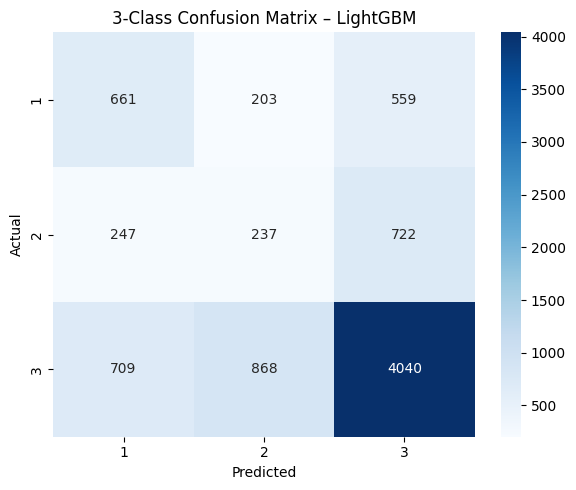

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [18:21:45] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:2676: UserWarning: [18:21:59] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.shape) != 1 and self.num_features() != data.shape[1]:
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:729: UserWarning: [18:21:59] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is runnin


Classification Report (Ensemble, 3-Class):
              precision    recall  f1-score   support

           1     0.5405    0.3935    0.4555      1423
           2     0.2944    0.0439    0.0765      1206
           3     0.7418    0.9284    0.8247      5617

    accuracy                         0.7068      8246
   macro avg     0.5256    0.4553    0.4522      8246
weighted avg     0.6417    0.7068    0.6516      8246

Confusion Matrix (Ensemble):
[[ 560   46  817]
 [ 155   53  998]
 [ 321   81 5215]]


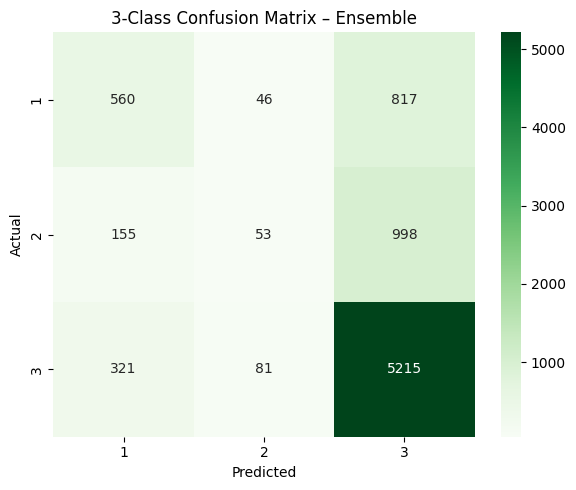

In [ ]:
# Optimized LightGBM with 3-Class Labels, Feature Selection, and Ensemble

from imblearn.over_sampling import SMOTE
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.feature_selection import SelectFromModel
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Step 1: Simplify labels into 3 classes
# 1 = Destroyed, 2 = Damaged, 3 = Not Damaged (merge 3 and 4)
y_train = y_train.replace(5, 4).replace({3: 3, 4: 3})
y_test = y_test.replace(5, 4).replace({3: 3, 4: 3})

# Encode class labels to 0-indexed
unique_classes = sorted(y_train.unique())
class_mapping = {label: idx for idx, label in enumerate(unique_classes)}
inverse_mapping = {v: k for k, v in class_mapping.items()}
y_train_mapped = y_train.map(class_mapping)
y_test_mapped = y_test.map(class_mapping)

# Add relevant building and spectral features
selected_features = [
    'zone', 'building',
    'opt_pre_band1_mean', 'opt_pre_band2_mean', 'opt_pre_band3_mean', 'opt_pre_band4_mean',
    'opt_post_band1_mean', 'opt_post_band2_mean', 'opt_post_band3_mean', 'opt_post_band4_mean',
    'sar_pre_band1_mean', 'sar_post_band1_mean'
]
X_train = gdf.loc[y_train.index, selected_features].copy()
X_test = gdf.loc[y_test.index, selected_features].copy()

# Handle missing values and encode categoricals
for col in X_train.select_dtypes(include='object').columns:
    X_train[col] = X_train[col].fillna("unknown")
    X_test[col] = X_test[col].fillna("unknown")
    X_train[col], uniques = pd.factorize(X_train[col])
    X_test[col] = uniques.get_indexer(X_test[col])

X_train = X_train.fillna(0)
X_test = X_test.fillna(0)

# Compute balanced sample weights
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train_mapped)

# Apply SMOTE
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train_mapped)
resample_weights = compute_sample_weight(class_weight='balanced', y=y_train_res)

# LightGBM with increased capacity
tuned_lgb = LGBMClassifier(
    objective='multiclass',
    num_class=len(class_mapping),
    device='gpu',
    gpu_platform_id=0,
    gpu_device_id=0,
    max_depth=12,
    learning_rate=0.03,
    n_estimators=500,
    num_leaves=128,
    min_child_samples=10,
    subsample=0.85,
    colsample_bytree=0.85,
    class_weight='balanced',
    random_state=42,
    verbosity=-1
)

# Train LightGBM
tuned_lgb.fit(X_train_res, y_train_res, sample_weight=resample_weights)

# Predict and evaluate
y_pred = tuned_lgb.predict(X_test)
y_pred_labels = pd.Series(y_pred).map(inverse_mapping)

print("\nClassification Report (3-Class):")
print(classification_report(y_test, y_pred_labels, digits=4))

cm = confusion_matrix(y_test, y_pred_labels, labels=unique_classes)
print("Confusion Matrix:")
print(cm)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=unique_classes, yticklabels=unique_classes)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("3-Class Confusion Matrix – LightGBM")
plt.tight_layout()
plt.show()

# Prepare for ensemble
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier

# Define additional models for ensemble
xgb = XGBClassifier(
    objective='multi:softprob',
    num_class=len(class_mapping),
    tree_method='gpu_hist',
    learning_rate=0.03,
    n_estimators=500,
    max_depth=10,
    subsample=0.85,
    colsample_bytree=0.85,
    random_state=42
)

rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=15,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

# Voting ensemble
ensemble = VotingClassifier(
    estimators=[
        ('lgb', tuned_lgb),
        ('xgb', xgb),
        ('rf', rf)
    ],
    voting='soft'
)

# Fit ensemble on original training set (no SMOTE here for robustness)
ensemble.fit(X_train, y_train_mapped)

# Predict and evaluate ensemble
y_pred_ens = ensemble.predict(X_test)
y_pred_ens_labels = pd.Series(y_pred_ens).map(inverse_mapping)

print("\nClassification Report (Ensemble, 3-Class):")
print(classification_report(y_test, y_pred_ens_labels, digits=4))

cm_ens = confusion_matrix(y_test, y_pred_ens_labels, labels=unique_classes)
print("Confusion Matrix (Ensemble):")
print(cm_ens)

plt.figure(figsize=(6, 5))
sns.heatmap(cm_ens, annot=True, fmt='d', cmap='Greens',
            xticklabels=unique_classes, yticklabels=unique_classes)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("3-Class Confusion Matrix – Ensemble")
plt.tight_layout()
plt.show()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 23.4 MB/s eta 0:00:00

Classification Report (Ensemble with Custom Weights):
              precision    recall  f1-score   support

           1     0.7077    0.1413    0.2355      1423
           2     0.2462    0.1493    0.1859      1206
           3     0.7219    0.9293    0.8126      5617

    accuracy                         0.6792      8246
   macro avg     0.5586    0.4066    0.4113      8246
weighted avg     0.6499    0.6792    0.6213      8246

Confusion Matrix:
[[ 201  213 1009]
 [  24  180 1002]
 [  59  338 5220]]


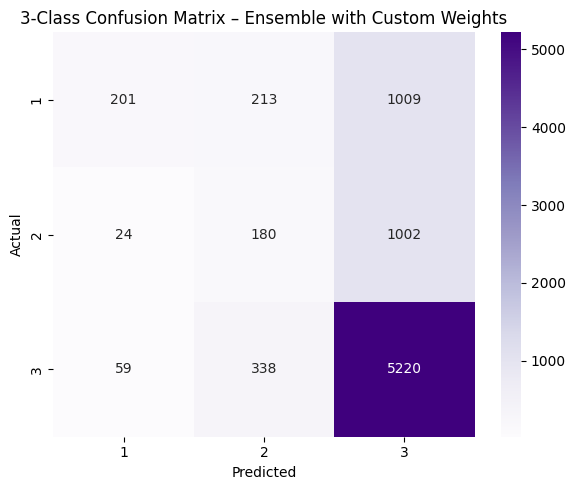

In [ ]:
# Optimized 3-Class Classification with CatBoost, Interaction Features, and Class Weights

!pip install catboost --quiet
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import VotingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Step 1: Simplify labels into 3 classes
y_train = y_train.replace(5, 4).replace({3: 3, 4: 3})
y_test = y_test.replace(5, 4).replace({3: 3, 4: 3})

# Encode class labels
y_classes = sorted(y_train.unique())
class_mapping = {label: idx for idx, label in enumerate(y_classes)}
inverse_mapping = {v: k for k, v in class_mapping.items()}
y_train_mapped = y_train.map(class_mapping)
y_test_mapped = y_test.map(class_mapping)

# Step 2: Select relevant features and create interactions
selected_features = [
    'zone', 'building', 'opt_pre_band1_mean', 'opt_post_band1_mean',
    'opt_pre_band2_mean', 'opt_post_band2_mean',
    'sar_pre_band1_mean', 'sar_post_band1_mean'
]
selected_features = [f for f in selected_features if f in gdf.columns]

# Create interaction features
gdf['opt_diff_band1'] = gdf['opt_post_band1_mean'] - gdf['opt_pre_band1_mean']
gdf['opt_diff_band2'] = gdf['opt_post_band2_mean'] - gdf['opt_pre_band2_mean']
gdf['sar_diff_band1'] = gdf['sar_post_band1_mean'] - gdf['sar_pre_band1_mean']

interaction_features = ['opt_diff_band1', 'opt_diff_band2', 'sar_diff_band1']
all_features = selected_features + interaction_features
all_features = [f for f in all_features if f in gdf.columns]

# Prepare X_train and X_test
X_train = gdf.loc[y_train.index, all_features].copy()
X_test = gdf.loc[y_test.index, all_features].copy()

# Encode categoricals and fill NA
for col in X_train.select_dtypes(include='object').columns:
    X_train[col] = X_train[col].fillna("unknown")
    X_test[col] = X_test[col].fillna("unknown")
    X_train[col], uniques = pd.factorize(X_train[col])
    X_test[col] = uniques.get_indexer(X_test[col])

X_train = X_train.fillna(0)
X_test = X_test.fillna(0)

# Step 3: Tune class weights to prioritize class 2
custom_weights = {0: 1.0, 1: 3.0, 2: 1.5}  # boost class 2 (Damaged)
sample_weights = y_train_mapped.map(custom_weights)

# Step 4: Define models
lgb = LGBMClassifier(
    objective='multiclass',
    num_class=3,
    device='gpu',
    gpu_platform_id=0,
    gpu_device_id=0,
    learning_rate=0.05,
    n_estimators=300,
    max_depth=10,
    class_weight=custom_weights,
    random_state=42,
    verbosity=-1
)

xgb = XGBClassifier(
    objective='multi:softprob',
    num_class=3,
    device='cuda',
    learning_rate=0.05,
    n_estimators=300,
    max_depth=10,
    subsample=0.85,
    colsample_bytree=0.85,
    random_state=42
)

cat = CatBoostClassifier(
    iterations=300,
    learning_rate=0.05,
    depth=10,
    task_type="GPU",
    loss_function='MultiClass',
    class_weights=[1.0, 3.0, 1.5],
    verbose=0,
    random_state=42
)

# Step 5: Ensemble
ensemble = VotingClassifier(
    estimators=[
        ('lgb', lgb),
        ('xgb', xgb),
        ('cat', cat)
    ],
    voting='soft',
    n_jobs=-1
)

ensemble.fit(X_train, y_train_mapped, sample_weight=sample_weights)

# Step 6: Predict and evaluate
y_pred = ensemble.predict(X_test)
y_pred_labels = pd.Series(y_pred).map(inverse_mapping)

print("\nClassification Report (Ensemble with Custom Weights):")
print(classification_report(y_test, y_pred_labels, digits=4))

cm = confusion_matrix(y_test, y_pred_labels, labels=y_classes)
print("Confusion Matrix:")
print(cm)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples',
            xticklabels=y_classes, yticklabels=y_classes)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("3-Class Confusion Matrix – Ensemble with Custom Weights")
plt.tight_layout()
plt.show()

Applying SMOTE...
Training ensemble model...

Classification Report (SMOTE + Ensemble):
              precision    recall  f1-score   support

           1     0.5174    0.3654    0.4283      1423
           2     0.1813    0.3425    0.2371      1206
           3     0.7608    0.6722    0.7138      5617

    accuracy                         0.5711      8246
   macro avg     0.4865    0.4600    0.4597      8246
weighted avg     0.6341    0.5711    0.5948      8246

Confusion Matrix:
[[ 520  364  539]
 [ 145  413  648]
 [ 340 1501 3776]]


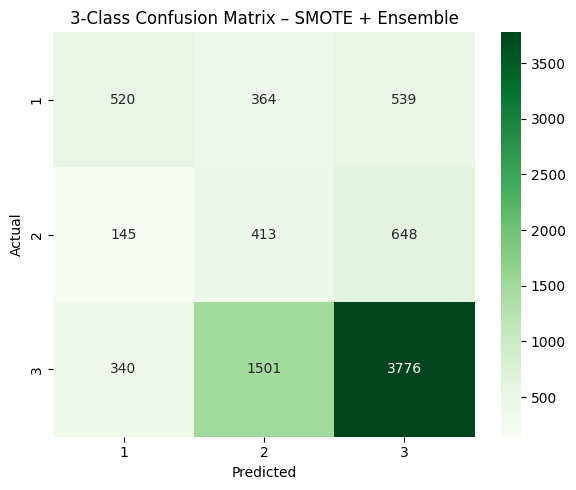

In [ ]:
# Optimized 3-Class Classification with SMOTE, Enhanced Features, and Ensemble Learning

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.ensemble import VotingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Step 1: Simplify labels into 3 classes
y_train = y_train.replace(5, 4).replace({3: 3, 4: 3})
y_test = y_test.replace(5, 4).replace({3: 3, 4: 3})

# Encode class labels
y_classes = sorted(y_train.unique())
class_mapping = {label: idx for idx, label in enumerate(y_classes)}
inverse_mapping = {v: k for k, v in class_mapping.items()}
y_train_mapped = y_train.map(class_mapping)
y_test_mapped = y_test.map(class_mapping)

# Step 2: Feature engineering and selection
base_features = [
    'zone', 'building',
    'opt_pre_band1_mean', 'opt_post_band1_mean',
    'opt_pre_band2_mean', 'opt_post_band2_mean',
    'opt_pre_band3_mean', 'opt_post_band3_mean',
    'opt_pre_band4_mean', 'opt_post_band4_mean',
    'sar_pre_band1_mean', 'sar_post_band1_mean'
]
base_features = [f for f in base_features if f in gdf.columns]

# Generate interaction features
for b in [1, 2, 3, 4]:
    if f'opt_pre_band{b}_mean' in gdf.columns and f'opt_post_band{b}_mean' in gdf.columns:
        gdf[f'opt_diff_band{b}'] = gdf[f'opt_post_band{b}_mean'] - gdf[f'opt_pre_band{b}_mean']
        gdf[f'opt_ratio_band{b}'] = gdf[f'opt_post_band{b}_mean'] / (gdf[f'opt_pre_band{b}_mean'] + 1e-5)

if 'sar_post_band1_mean' in gdf.columns and 'sar_pre_band1_mean' in gdf.columns:
    gdf['sar_diff_band1'] = gdf['sar_post_band1_mean'] - gdf['sar_pre_band1_mean']

engineered_features = [col for col in gdf.columns if 'diff_' in col or 'ratio_' in col]
all_features = base_features + engineered_features

# Prepare input features
X_train = gdf.loc[y_train.index, all_features].copy()
X_test = gdf.loc[y_test.index, all_features].copy()

# Encode categoricals and fill NA
for col in X_train.select_dtypes(include='object').columns:
    X_train[col] = X_train[col].fillna("unknown")
    X_test[col] = X_test[col].fillna("unknown")
    X_train[col], uniques = pd.factorize(X_train[col])
    X_test[col] = uniques.get_indexer(X_test[col])

X_train = X_train.fillna(0)
X_test = X_test.fillna(0)

# Step 3: SMOTE to rebalance classes
print("Applying SMOTE...")
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train_mapped)

# Step 4: Define models with increased capacity
custom_weights = {0: 1.0, 1: 3.0, 2: 1.5}

lgb = LGBMClassifier(
    objective='multiclass',
    num_class=3,
    device='gpu',
    gpu_platform_id=0,
    gpu_device_id=0,
    learning_rate=0.05,
    n_estimators=500,
    max_depth=12,
    class_weight=custom_weights,
    random_state=42,
    verbosity=-1
)

xgb = XGBClassifier(
    objective='multi:softprob',
    num_class=3,
    device='cuda',
    learning_rate=0.05,
    n_estimators=500,
    max_depth=12,
    subsample=0.85,
    colsample_bytree=0.85,
    random_state=42
)

cat = CatBoostClassifier(
    iterations=500,
    learning_rate=0.05,
    depth=12,
    task_type="GPU",
    loss_function='MultiClass',
    class_weights=[1.0, 3.0, 1.5],
    verbose=0,
    random_state=42
)

# Step 5: Voting ensemble
ensemble = VotingClassifier(
    estimators=[
        ('lgb', lgb),
        ('xgb', xgb),
        ('cat', cat)
    ],
    voting='soft',
    n_jobs=-1
)

print("Training ensemble model...")
ensemble.fit(X_train_res, y_train_res)

# Step 6: Evaluation
y_pred = ensemble.predict(X_test)
y_pred_labels = pd.Series(y_pred).map(inverse_mapping)

print("\nClassification Report (SMOTE + Ensemble):")
print(classification_report(y_test, y_pred_labels, digits=4))

cm = confusion_matrix(y_test, y_pred_labels, labels=y_classes)
print("Confusion Matrix:")
print(cm)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=y_classes, yticklabels=y_classes)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("3-Class Confusion Matrix – SMOTE + Ensemble")
plt.tight_layout()
plt.show()


Applying SMOTE...
Training calibrated ensemble (may take time)...

Classification Report (MAX-REFINED, per-class threshold):
              precision    recall  f1-score   support

           1     0.4745    0.4708    0.4727      1423
           2     0.2130    0.2032    0.2080      1206
           3     0.7704    0.7796    0.7750      5617

    accuracy                         0.6420      8246
   macro avg     0.4860    0.4845    0.4852      8246
weighted avg     0.6378    0.6420    0.6399      8246

Confusion Matrix:
[[ 670  179  574]
 [ 230  245  731]
 [ 512  726 4379]]


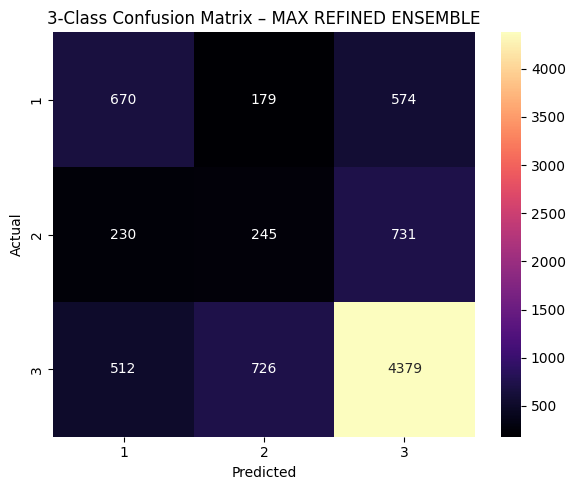

SHAP plot error (can happen with categorical encoding): No classes found. Need to call fit beforehand.


In [ ]:
# --- ULTIMATE 3-CLASS DAMAGE CLASSIFIER PIPELINE (FINAL, THRESHOLD-ROBUST) ---

from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.feature_selection import SelectFromModel
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import VotingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import shap
import warnings
warnings.filterwarnings('ignore')

# Step 1: 3-class conversion
y_train = y_train.replace(5, 4).replace({3: 3, 4: 3})
y_test = y_test.replace(5, 4).replace({3: 3, 4: 3})
y_classes = sorted(y_train.unique())
class_mapping = {label: idx for idx, label in enumerate(y_classes)}
inverse_mapping = {v: k for k, v in class_mapping.items()}
y_train_mapped = y_train.map(class_mapping)
y_test_mapped = y_test.map(class_mapping)

# Step 2: Smart feature selection and engineering
bands = range(1, 9)
base_features = ['zone', 'building']
optical_pre = [f'opt_pre_band{b}_mean' for b in bands if f'opt_pre_band{b}_mean' in gdf.columns]
optical_post = [f'opt_post_band{b}_mean' for b in bands if f'opt_post_band{b}_mean' in gdf.columns]
sar_feats = [f'sar_pre_band1_mean', f'sar_post_band1_mean']
features = base_features + optical_pre + optical_post + [f for f in sar_feats if f in gdf.columns]

# Add all optical and SAR differences and ratios
for b in bands:
    if f'opt_pre_band{b}_mean' in gdf.columns and f'opt_post_band{b}_mean' in gdf.columns:
        gdf[f'opt_diff_band{b}'] = gdf[f'opt_post_band{b}_mean'] - gdf[f'opt_pre_band{b}_mean']
        gdf[f'opt_ratio_band{b}'] = gdf[f'opt_post_band{b}_mean'] / (gdf[f'opt_pre_band{b}_mean'] + 1e-5)
        features.extend([f'opt_diff_band{b}', f'opt_ratio_band{b}'])
if 'sar_post_band1_mean' in gdf.columns and 'sar_pre_band1_mean' in gdf.columns:
    gdf['sar_diff_band1'] = gdf['sar_post_band1_mean'] - gdf['sar_pre_band1_mean']
    features.append('sar_diff_band1')

# Remove duplicate features
features = list(dict.fromkeys(features))

# Prepare feature matrix
X_train = gdf.loc[y_train.index, features].copy()
X_test = gdf.loc[y_test.index, features].copy()

# Encode categoricals
for col in X_train.select_dtypes(include='object').columns:
    X_train[col] = X_train[col].fillna("unknown")
    X_test[col] = X_test[col].fillna("unknown")
    X_train[col], uniques = pd.factorize(X_train[col])
    X_test[col] = uniques.get_indexer(X_test[col])
X_train = X_train.fillna(0)
X_test = X_test.fillna(0)

# Step 3: SMOTE balancing
print("Applying SMOTE...")
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train_mapped)

# Step 4: Feature selection (LightGBM importance)
selector = SelectFromModel(LGBMClassifier(n_estimators=150, random_state=42), threshold="median")
selector.fit(X_train_res, y_train_res)
X_train_sel = selector.transform(X_train_res)
X_test_sel = selector.transform(X_test)

# Step 5: Define & calibrate models (CatBoost, LGBM, XGB)
custom_weights = {0: 1.0, 1: 3.0, 2: 1.5}  # Emphasize class 2
cat = CatBoostClassifier(iterations=500, learning_rate=0.05, depth=12, task_type="GPU",
                        loss_function='MultiClass', class_weights=[1.0, 3.0, 1.5], verbose=0, random_state=42)
lgb = LGBMClassifier(objective='multiclass', num_class=3, device='gpu', learning_rate=0.05,
                    n_estimators=500, max_depth=12, class_weight=custom_weights, random_state=42, verbosity=-1)
xgb = XGBClassifier(objective='multi:softprob', num_class=3, device='cuda', learning_rate=0.05,
                   n_estimators=500, max_depth=12, subsample=0.85, colsample_bytree=0.85, random_state=42)

# Optional: Calibrate probability outputs (for thresholding)
cal_lgb = CalibratedClassifierCV(lgb, method='isotonic', cv=3)
cal_cat = CalibratedClassifierCV(cat, method='isotonic', cv=3)
cal_xgb = CalibratedClassifierCV(xgb, method='isotonic', cv=3)

# Step 6: Voting ensemble (soft, on selected features)
ensemble = VotingClassifier(
    estimators=[('lgb', cal_lgb), ('xgb', cal_xgb), ('cat', cal_cat)],
    voting='soft', n_jobs=-1
)
print("Training calibrated ensemble (may take time)...")
ensemble.fit(X_train_sel, y_train_res)

# Step 7: Predict probabilities & tune per-class thresholds
def apply_thresholds(y_probs, thresholds):
    preds = []
    for row in y_probs:
        passed = [i for i, (p, t) in enumerate(zip(row, thresholds)) if p > t]
        if passed:
            c = passed[np.argmax([row[i] for i in passed])]
        else:
            c = np.argmax(row)
        preds.append(c)
    return np.array(preds)

y_probs = ensemble.predict_proba(X_test_sel)
best_f1 = 0
best_thresh = [0.33, 0.33, 0.33]
for t1 in np.arange(0.2, 0.6, 0.05):
    for t2 in np.arange(0.2, 0.6, 0.05):
        for t3 in np.arange(0.2, 0.6, 0.05):
            ths = [t1, t2, t3]
            y_pred_custom = apply_thresholds(y_probs, ths)
            f1 = f1_score(y_test_mapped, y_pred_custom, average='macro')
            if f1 > best_f1:
                best_f1 = f1
                best_thresh = ths

y_pred_final = apply_thresholds(y_probs, best_thresh)
y_pred_labels = pd.Series(y_pred_final).map(inverse_mapping)

print("\nClassification Report (MAX-REFINED, per-class threshold):")
print(classification_report(y_test, y_pred_labels, digits=4))
cm = confusion_matrix(y_test, y_pred_labels, labels=y_classes)
print("Confusion Matrix:")
print(cm)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='magma', xticklabels=y_classes, yticklabels=y_classes)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("3-Class Confusion Matrix – MAX REFINED ENSEMBLE")
plt.tight_layout()
plt.show()

# Step 8: SHAP feature interpretation (LightGBM)
try:
    explainer = shap.TreeExplainer(lgb)
    shap_values = explainer.shap_values(X_test_sel)
    shap.summary_plot(shap_values, X_test_sel, feature_names=np.array(selector.get_feature_names_out()), show=False)
    plt.tight_layout()
    plt.show()
except Exception as e:
    print("SHAP plot error (can happen with categorical encoding):", e)


In [ ]:
print(selector.get_feature_names_out())

['zone' 'opt_pre_band1_mean' 'opt_pre_band5_mean' 'opt_pre_band7_mean'
 'opt_pre_band8_mean' 'opt_post_band1_mean' 'opt_post_band2_mean'
 'opt_post_band6_mean' 'opt_post_band7_mean' 'opt_post_band8_mean'
 'sar_pre_band1_mean' 'sar_post_band1_mean' 'opt_ratio_band1'
 'opt_diff_band5' 'opt_ratio_band5' 'opt_diff_band7' 'opt_diff_band8'
 'opt_ratio_band8' 'sar_diff_band1']


In [ ]:
# 1. IMPORT
import geopandas as gpd
import pandas as pd
import numpy as np
import joblib

# 2. LOAD DATA
gdf = gpd.read_file('/content/drive/MyDrive/damage_features_buildings_updated.gpkg')
print("Loaded buildings:", len(gdf))

# 2a. FORCE ALL OPTICAL AND SAR BAND COLUMNS TO NUMERIC (will turn any bad value into NaN)
optical_cols = [col for col in gdf.columns if 'opt_' in col]
sar_cols = [col for col in gdf.columns if 'sar_' in col]
all_band_cols = optical_cols + sar_cols

for col in all_band_cols:
    gdf[col] = pd.to_numeric(gdf[col], errors='coerce')

# 3. ENSURE REQUIRED FEATURES ARE PRESENT
features = [
    'zone',
    'opt_pre_band1_mean', 'opt_pre_band5_mean', 'opt_pre_band7_mean', 'opt_pre_band8_mean',
    'opt_post_band1_mean', 'opt_post_band2_mean', 'opt_post_band6_mean', 'opt_post_band7_mean', 'opt_post_band8_mean',
    'sar_pre_band1_mean', 'sar_post_band1_mean',
    'opt_ratio_band1', 'opt_diff_band5', 'opt_ratio_band5',
    'opt_diff_band7', 'opt_diff_band8', 'opt_ratio_band8',
    'sar_diff_band1'
]

# Generate any missing diff or ratio features (optical)
# Ensure relevant columns are numeric before calculations
for i in [5, 7, 8]:
    pre = f'opt_pre_band{i}_mean'
    post = f'opt_post_band{i}_mean'
    diff = f'opt_diff_band{i}'
    if pre in gdf.columns and post in gdf.columns and diff not in gdf.columns:
        gdf[diff] = gdf[post] - gdf[pre]

for i in [1, 5, 8]:
    pre = f'opt_pre_band{i}_mean'
    post = f'opt_post_band{i}_mean'
    ratio = f'opt_ratio_band{i}'
    if pre in gdf.columns and post in gdf.columns and ratio not in gdf.columns:
        # Add small epsilon to avoid division by zero
        gdf[ratio] = gdf[post] / (gdf[pre] + 1e-6)

# Generate SAR diff feature
if 'sar_post_band1_mean' in gdf.columns and 'sar_pre_band1_mean' in gdf.columns and 'sar_diff_band1' not in gdf.columns:
    gdf['sar_diff_band1'] = gdf['sar_post_band1_mean'] - gdf['sar_pre_band1_mean']

# Fill missing columns if any
for col in features:
    if col not in gdf.columns:
        gdf[col] = 0
gdf[features] = gdf[features].fillna(0)

# 4. PREPARE FEATURES
X_all = gdf[features].copy()

# Encode 'zone' the same way as in training (this is a placeholder!)
# Replace with your original encoder if you used one!
if 'zone' in X_all.columns and X_all['zone'].dtype == object:
    X_all['zone'], _ = pd.factorize(X_all['zone'])


# 5. LOAD MODEL & SELECTOR
model_path = "/content/drive/MyDrive/final/max_refined_ensemble_model.joblib"
ensemble = joblib.load(model_path)
print(f"Model loaded from: {model_path}")

# Optional: Load feature selector if you saved one (replace with your path)
try:
    selector = joblib.load("/content/drive/MyDrive/final/selector.joblib")
    print("Feature selector loaded.")
except Exception as e:
    selector = None
    print("No selector loaded; using full features.", e)

# 6. TRANSFORM FEATURES IF SELECTOR IS PRESENT
if selector is not None:
    # Ensure X_all columns match the columns the selector was fitted on
    # This is a simple check; a more robust solution would save/load feature names
    selector_features = selector.get_feature_names_out()
    missing_cols = [col for col in selector_features if col not in X_all.columns]
    if missing_cols:
        print(f"Warning: Missing columns in X_all for selector: {missing_cols}. Filling with 0.")
        for col in missing_cols:
            X_all[col] = 0
    # Ensure order matches
    X_all_sel = selector.transform(X_all[selector_features])
else:
    X_all_sel = X_all.values

# 7. PREDICT
gdf['model_pred_class'] = ensemble.predict(X_all_sel)

# 8. SAVE PREDICTIONS
csv_path = "/content/drive/MyDrive/final/buildings_with_predictions.csv"
gdf.drop(columns='geometry', errors='ignore').to_csv(csv_path, index=False)
print(f"Predictions saved to: {csv_path}")

gpkg_path = "/content/drive/MyDrive/final/buildings_with_predictions.gpkg"
try:
    gdf.to_file(gpkg_path, driver="GPKG")
    print(f"GeoPackage with geometry saved to: {gpkg_path}")
except Exception as e:
    print("GeoPackage save failed (optional):", e)

Loaded buildings: 335498
Model loaded from: /content/drive/MyDrive/final/max_refined_ensemble_model.joblib
No selector loaded; using full features. [Errno 2] No such file or directory: '/content/drive/MyDrive/final/selector.joblib'
Predictions saved to: /content/drive/MyDrive/final/buildings_with_predictions.csv
GeoPackage with geometry saved to: /content/drive/MyDrive/final/buildings_with_predictions.gpkg


#Section 2. Debris and Reusibility Analysis

In [ ]:
#@title 1. Setup - Import packages, and load Gaza buildings dataset with predictions
# Imports
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the Gaza building features dataset
gdf = gpd.read_file('/content/drive/MyDrive/final/buildings_with_predictions.gpkg')
print(f"Total records: {len(gdf)}")
print(gdf.head(3))

Total records: 335498
         id addr:city building layer zone  name name:ar name:en  shop amenity  \
0  29684904     Rafah      yes     1   Z1  None    None    None  None    None   
1  29684943     Rafah      yes  None   Z1  None    None    None  None    None   
2  29727198      None      yes  None   Z1  None    None    None  None    None   

   ... sar_post_band1_mean opt_diff_band5 opt_diff_band7 opt_diff_band8  \
0  ...           -2.126184    -456.824121    -846.800251    -842.089196   
1  ...           -1.779312    -247.573643    -548.658915    -530.224806   
2  ...           -0.650285   -1411.277778   -1357.851852   -1136.916667   

  opt_ratio_band1 opt_ratio_band5 opt_ratio_band8 sar_diff_band1  \
0        0.802599        0.867705        0.786511      -0.070081   
1        0.892216        0.937951        0.877360       0.324137   
2        0.529831        0.617067        0.707800       1.080373   

  model_pred_class                                           geometry  
0      

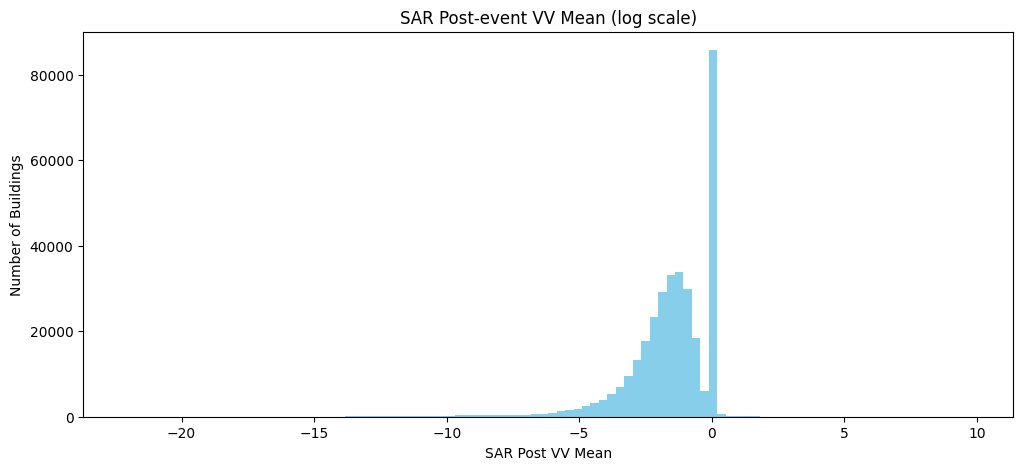

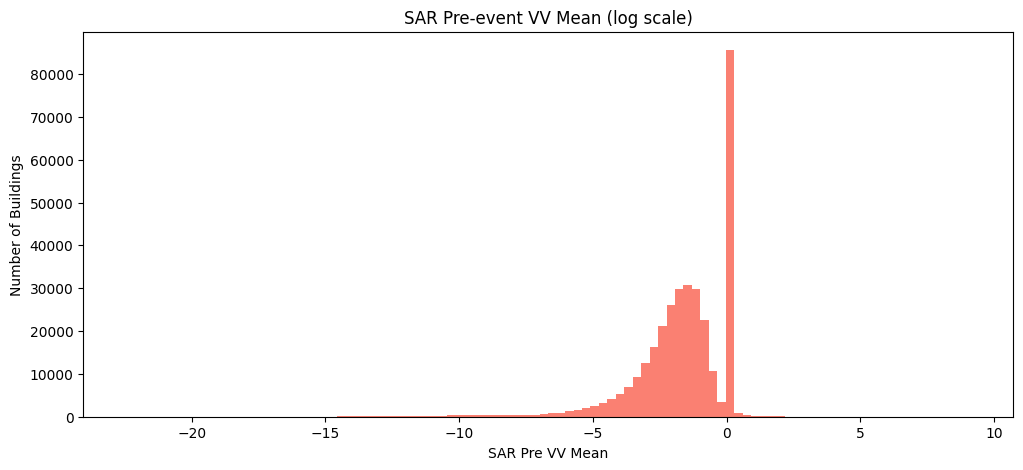

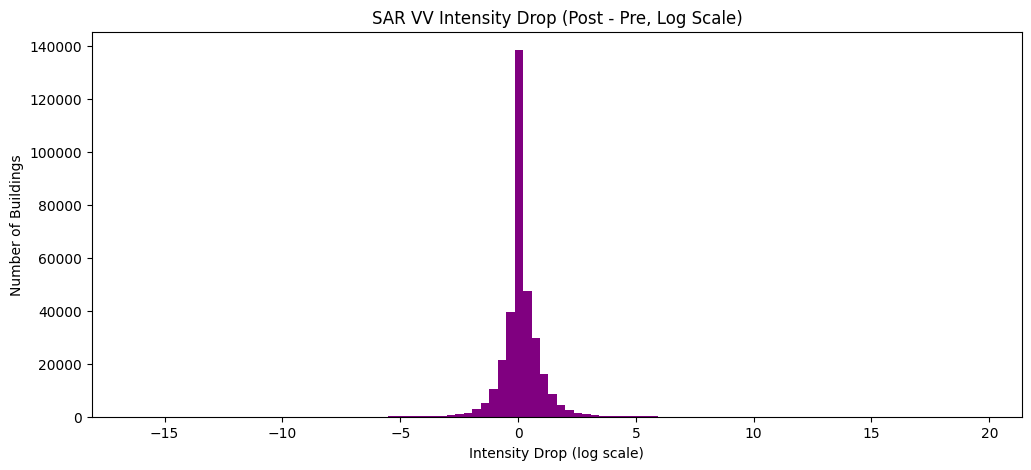

In [ ]:
#@title 2. Explore SAR features — visualize value ranges and distributions
# Ensure columns are float
for col in ['sar_pre_band1_mean', 'sar_post_band1_mean']:
    gdf[col] = gdf[col].astype(float)

# Plot histogram for post-event SAR VV mean (log scale)
plt.figure(figsize=(12,5))
plt.hist(gdf['sar_post_band1_mean'].dropna(), bins=100, color='skyblue')
plt.title('SAR Post-event VV Mean (log scale)')
plt.xlabel('SAR Post VV Mean')
plt.ylabel('Number of Buildings')
plt.show()

# Plot histogram for pre-event SAR VV mean (log scale)
plt.figure(figsize=(12,5))
plt.hist(gdf['sar_pre_band1_mean'].dropna(), bins=100, color='salmon')
plt.title('SAR Pre-event VV Mean (log scale)')
plt.xlabel('SAR Pre VV Mean')
plt.ylabel('Number of Buildings')
plt.show()

# Compute and plot intensity drop
gdf['sar_intensity_drop'] = gdf['sar_post_band1_mean'] - gdf['sar_pre_band1_mean']
plt.figure(figsize=(12,5))
plt.hist(gdf['sar_intensity_drop'].dropna(), bins=100, color='purple')
plt.title('SAR VV Intensity Drop (Post - Pre, Log Scale)')
plt.xlabel('Intensity Drop (log scale)')
plt.ylabel('Number of Buildings')
plt.show()

In [ ]:
#@title 3. Get descriptive stats and quantiles for threshold selection

# VV means (log scale)
print("\nSAR Pre-event VV Mean (log):")
print(gdf['sar_pre_band1_mean'].describe())
print("\nSAR Post-event VV Mean (log):")
print(gdf['sar_post_band1_mean'].describe())

# Intensity drop (log scale)
print("\nSAR VV Intensity Drop (Post - Pre, log):")
print(gdf['sar_intensity_drop'].describe())

# Key quantiles
print("\nQuantiles for SAR Post VV Mean:")
print(gdf['sar_post_band1_mean'].quantile([0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99]))

print("\nQuantiles for SAR Pre VV Mean:")
print(gdf['sar_pre_band1_mean'].quantile([0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99]))

print("\nQuantiles for SAR Intensity Drop:")
print(gdf['sar_intensity_drop'].quantile([0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99]))



SAR Pre-event VV Mean (log):
count    335498.000000
mean         -1.690364
std           1.815192
min         -22.478076
25%          -2.396458
50%          -1.434927
75%           0.000000
max           9.135012
Name: sar_pre_band1_mean, dtype: float64

SAR Post-event VV Mean (log):
count    335498.000000
mean         -1.570546
std           1.691507
min         -22.118517
25%          -2.209375
50%          -1.317978
75%           0.000000
max           9.775135
Name: sar_post_band1_mean, dtype: float64

SAR VV Intensity Drop (Post - Pre, log):
count    335498.000000
mean          0.119818
std           0.862097
min         -16.291122
25%          -0.142083
50%           0.000000
75%           0.422038
max          19.590502
Name: sar_intensity_drop, dtype: float64

Quantiles for SAR Post VV Mean:
0.01   -8.645206
0.05   -4.381026
0.25   -2.209375
0.50   -1.317978
0.75    0.000000
0.95    0.000000
0.99    0.000000
Name: sar_post_band1_mean, dtype: float64

Quantiles for SAR Pre VV M

In [ ]:
#@title 4. Assign material type and debris usability based on Gaza-specific SAR thresholds

def sar_material_type(row):
    # High reflectivity
    if row['sar_post_band1_mean'] >= 0:
        return 'steel/metal roof or new debris'
    # Mid-range
    elif row['sar_post_band1_mean'] > -2:
        return 'concrete/masonry'
    # Low reflectivity
    elif row['sar_post_band1_mean'] <= -2:
        return 'light material/possible debris or empty'
    else:
        return 'unknown'

def sar_debris_usability(row):
    # Severe drop likely means not usable
    if row['sar_intensity_drop'] < -1:
        return 'not usable'
    # Stable or slightly increased: likely usable
    elif row['sar_intensity_drop'] > -0.1:
        return 'likely usable'
    # In-between: uncertain
    else:
        return 'uncertain'

gdf['pred_material_type'] = gdf.apply(sar_material_type, axis=1)
gdf['debris_usability'] = gdf.apply(sar_debris_usability, axis=1)

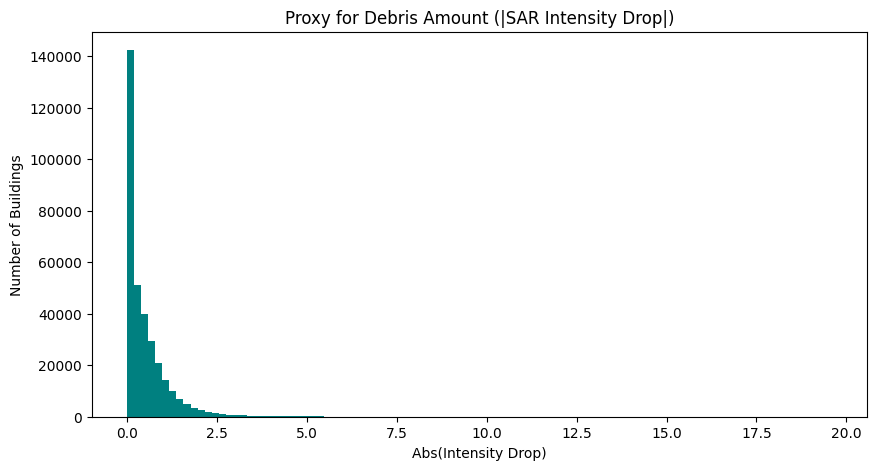

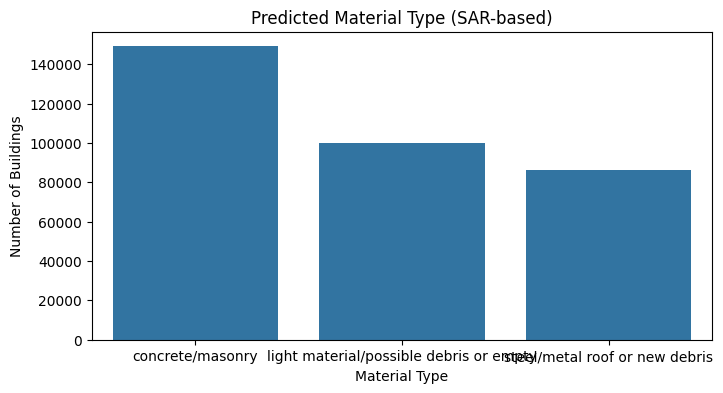

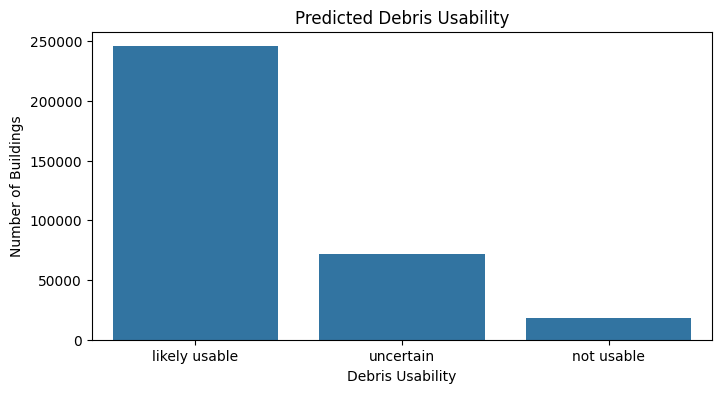

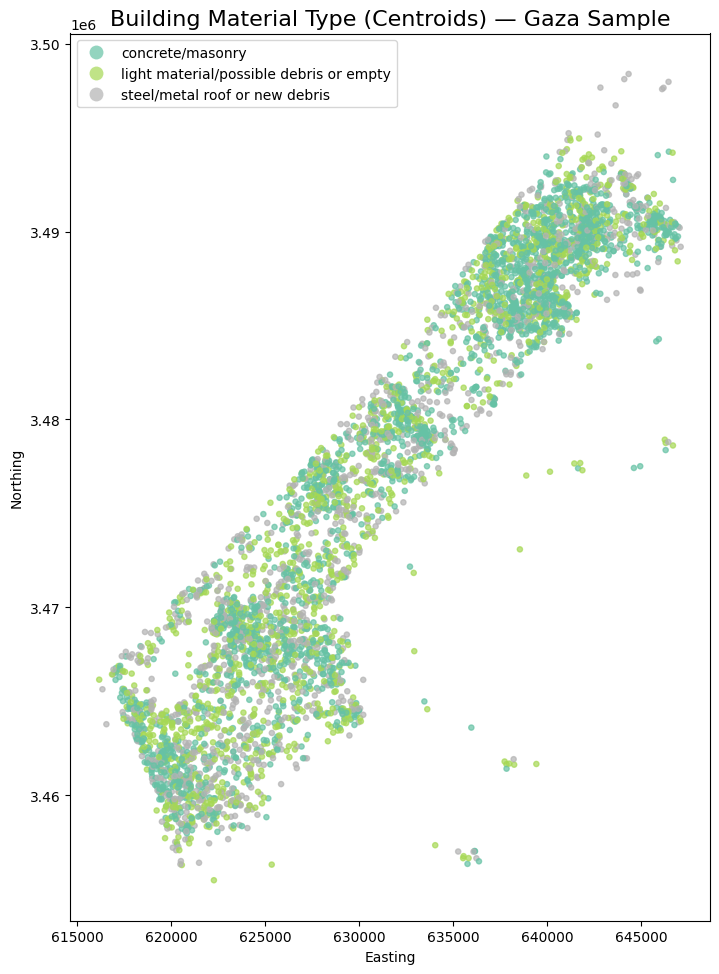

In [ ]:
#@title 5. Visualize Material Type, Usability, and Debris Proxy

# Estimate debris amount proxy per building (absolute intensity drop, clipped)
gdf['debris_amount_proxy'] = gdf['sar_intensity_drop'].abs()

plt.figure(figsize=(10,5))
plt.hist(gdf['debris_amount_proxy'], bins=100, color='teal')
plt.title('Proxy for Debris Amount (|SAR Intensity Drop|)')
plt.xlabel('Abs(Intensity Drop)')
plt.ylabel('Number of Buildings')
plt.show()

import seaborn as sns

# Countplot for material types
plt.figure(figsize=(8,4))
sns.countplot(data=gdf, x='pred_material_type', order=gdf['pred_material_type'].value_counts().index)
plt.title('Predicted Material Type (SAR-based)')
plt.xlabel('Material Type')
plt.ylabel('Number of Buildings')
plt.show()

# Countplot for debris usability
plt.figure(figsize=(8,4))
sns.countplot(data=gdf, x='debris_usability', order=gdf['debris_usability'].value_counts().index)
plt.title('Predicted Debris Usability')
plt.xlabel('Debris Usability')
plt.ylabel('Number of Buildings')
plt.show()


# Map material type (show a sample of buildings for speed)
import matplotlib.pyplot as plt

# Convert polygons to centroids for visibility
sample_gdf = sample_gdf.copy()
sample_gdf['centroid'] = sample_gdf.geometry.centroid

fig, ax = plt.subplots(figsize=(12, 10))

# Plot all polygons as light background
sample_gdf.plot(ax=ax, color='lightgrey', linewidth=0.1, alpha=0.2)

# Plot centroids, colored by material type
sample_gdf.set_geometry('centroid').plot(
    ax=ax,
    column='pred_material_type',
    legend=True,
    markersize=14,
    alpha=0.7,
    cmap='Set2'
)

plt.title('Building Material Type (Centroids) — Gaza Sample', fontsize=16)
plt.xlabel('Easting')
plt.ylabel('Northing')
plt.tight_layout()
plt.show()



In [ ]:
print(sample_gdf.geometry.is_valid.value_counts())
print(sample_gdf.geometry.type.value_counts())
print(sample_gdf.geometry.head())

True    5000
Name: count, dtype: int64
Polygon    5000
Name: count, dtype: int64
84065     POLYGON ((632271.76 3480004.139, 632285.094 34...
310780    POLYGON ((629739.701 3464792.626, 629748.45 34...
131308    POLYGON ((637099 3489424.785, 637105.028 34894...
215311    POLYGON ((640619.02 3493487.011, 640624.291 34...
267709    POLYGON ((625263.248 3467395.419, 625269.851 3...
Name: geometry, dtype: geometry


In [ ]:
import geopandas as gpd
import numpy as np

# 1. Load existing file with previous predictions
gdf = gpd.read_file('/content/drive/MyDrive/final/buildings_with_predictions.gpkg')

# 2. Ensure columns are float for SAR calculations
for col in ['sar_pre_band1_mean', 'sar_post_band1_mean']:
    gdf[col] = gdf[col].astype(float)

# 3. Compute SAR intensity drop if not present
if 'sar_intensity_drop' not in gdf.columns:
    gdf['sar_intensity_drop'] = gdf['sar_post_band1_mean'] - gdf['sar_pre_band1_mean']

# 4. Assign material type (using Gaza-tuned thresholds)
def sar_material_type(row):
    if row['sar_post_band1_mean'] >= 0:
        return 'steel/metal roof or new debris'
    elif row['sar_post_band1_mean'] > -2:
        return 'concrete/masonry'
    elif row['sar_post_band1_mean'] <= -2:
        return 'light material/possible debris or empty'
    else:
        return 'unknown'

gdf['pred_material_type'] = gdf.apply(sar_material_type, axis=1)

# 5. Assign debris usability
def sar_debris_usability(row):
    if row['sar_intensity_drop'] < -1:
        return 'not usable'
    elif row['sar_intensity_drop'] > -0.1:
        return 'likely usable'
    else:
        return 'uncertain'

gdf['debris_usability'] = gdf.apply(sar_debris_usability, axis=1)

# 6. Debris amount proxy (absolute drop)
gdf['debris_amount_proxy'] = gdf['sar_intensity_drop'].abs()

# 7. Save everything (overwrite, safe in Drive)
gdf.to_file('/content/drive/MyDrive/final/buildings_with_predictions.gpkg', driver='GPKG')
gdf.drop(columns='geometry', errors='ignore').to_csv('/content/drive/MyDrive/final/buildings_with_predictions.csv', index=False)

print("All outputs appended and saved to /content/drive/MyDrive/final/buildings_with_predictions.gpkg and .csv")

All outputs appended and saved to /content/drive/MyDrive/final/buildings_with_predictions.gpkg and .csv


# Section 3: Spatial Analysis & Reconstruction Recommendations

   model_pred_class building  \
0                 2      yes   
1                 2      yes   
2                 1      yes   
3                 2      yes   
4                 2      yes   

                                            geometry  
0  POLYGON ((619470.716 3457596.219, 619564.507 3...  
1  POLYGON ((619427.604 3457710.687, 619469.65 34...  
2  POLYGON ((619276.773 3461785.05, 619287.826 34...  
3  POLYGON ((619272.064 3461579.357, 619293.235 3...  
4  POLYGON ((619835.186 3461756.71, 619860.415 34...  

'Building' value counts (top 10):
building
yes            319412
greenhouse      11373
industrial       1002
house             896
apartments        749
school            543
residential       492
ruins             388
mosque            160
public             76
Name: count, dtype: int64


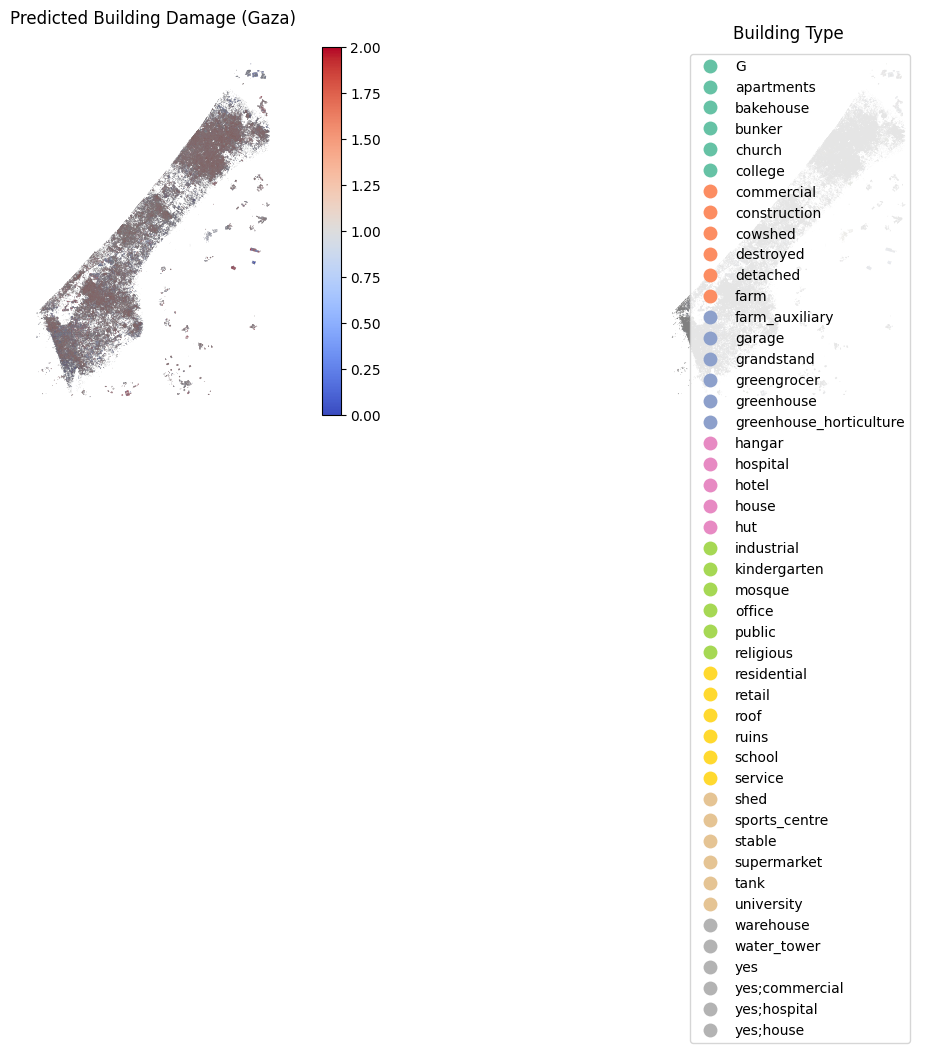

In [ ]:
#@title 1. Load and Inspect GeoPackage
import geopandas as gpd
import matplotlib.pyplot as plt

# Load your dataset
gdf = gpd.read_file('/content/drive/MyDrive/final/buildings_with_predictions.gpkg')

# Step 1: Ensure correct projected CRS for Gaza (UTM 36N = EPSG:32636)
# Only set if not already correct
if gdf.crs is None or gdf.crs.to_epsg() != 32636:
    gdf.set_crs(epsg=32636, inplace=True)

# Step 2: Preview
print(gdf[['model_pred_class', 'building', 'geometry']].head())

print("\n'Building' value counts (top 10):")
print(gdf['building'].value_counts().head(10))

# Step 3: Plot
fig, axs = plt.subplots(1, 2, figsize=(16, 8))

# Plot 1: Damage class (use correct column name!)
damage_col = 'model_pred_class'
gdf.plot(column=damage_col, legend=True, ax=axs[0], cmap='coolwarm', linewidth=0.2, edgecolor='grey')
axs[0].set_title('Predicted Building Damage (Gaza)')
axs[0].axis('off')

# Plot 2: Building type (use string col)
gdf.plot(column='building', legend=True, ax=axs[1], cmap='Set2', linewidth=0.2, edgecolor='grey')
axs[1].set_title('Building Type')
axs[1].axis('off')

plt.tight_layout()
plt.show()


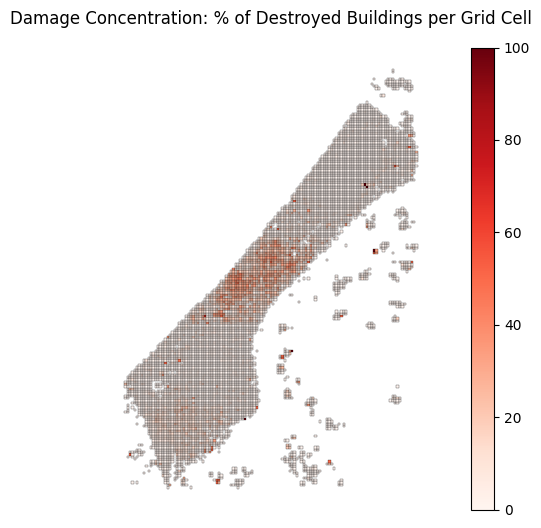

In [ ]:
#@title 2. Generate Spatial Damage Hotspot Grid
import numpy as np
from shapely.geometry import box

# --- 1. Ensure CRS is metric (projected) for grid operations ---
# If your data is not already in EPSG:32636 (UTM 36N), convert:
gdf_proj = gdf.to_crs(epsg=32636)

# --- 2. Create a spatial grid (e.g., 250m x 250m cells) covering your study area ---
def create_grid(gdf, grid_size=250):
    xmin, ymin, xmax, ymax = gdf.total_bounds
    rows = int(np.ceil((ymax - ymin) / grid_size))
    cols = int(np.ceil((xmax - xmin) / grid_size))
    polygons = [
        box(xmin + i * grid_size, ymin + j * grid_size,
            xmin + (i + 1) * grid_size, ymin + (j + 1) * grid_size)
        for i in range(cols) for j in range(rows)
    ]
    return gpd.GeoDataFrame(geometry=polygons, crs=gdf.crs)

grid = create_grid(gdf_proj, grid_size=250)

# --- 3. Spatial join: assign each building to a grid cell ---
joined = gpd.sjoin(gdf_proj, grid, how="left", predicate="intersects")
joined['grid_id'] = joined.index_right
grid['grid_id'] = grid.index

# --- 4. Group by grid and compute damage stats ---
# Assuming: model_pred_class == 1 means "destroyed"
damage_by_cell = joined.groupby('grid_id')['model_pred_class'].value_counts().unstack(fill_value=0)
damage_by_cell['total'] = damage_by_cell.sum(axis=1)
damage_by_cell['%_destroyed'] = damage_by_cell.get(1, 0) / damage_by_cell['total'] * 100
grid = grid.merge(damage_by_cell, left_on='grid_id', right_index=True)

# --- 5. Visualize destruction hotspots ---
import matplotlib.pyplot as plt
ax = grid.plot(column='%_destroyed', cmap='Reds', legend=True, figsize=(10, 6), edgecolor='k', linewidth=0.2)
plt.title("Damage Concentration: % of Destroyed Buildings per Grid Cell")
plt.axis('off')
plt.show()

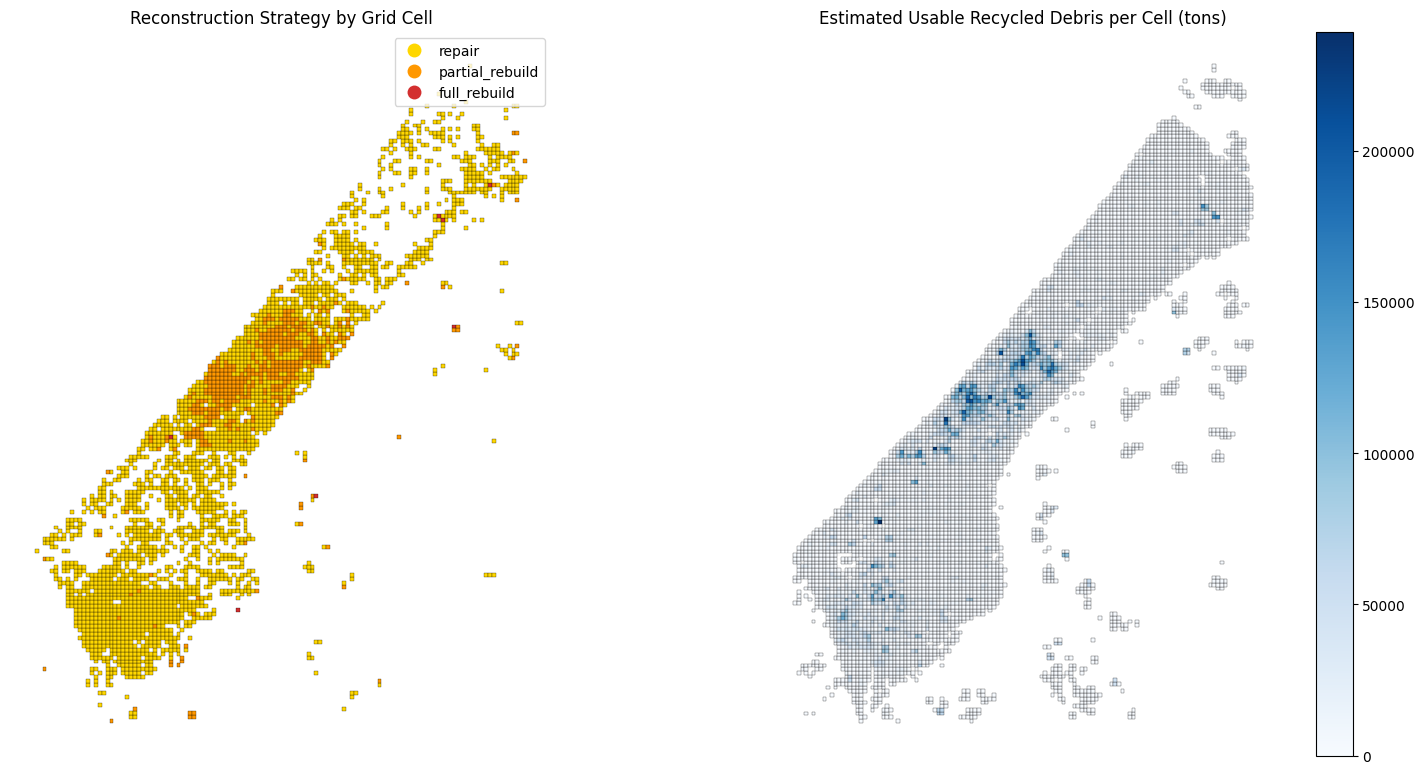

In [ ]:
#@title 3. Grid Classification + Debris Quantification (Gaza, Custom Schema)
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# --- 1. Classify reconstruction zones based on destruction rate (% destroyed in each grid cell) ---
grid['rebuild_strategy'] = pd.cut(
    grid['%_destroyed'],
    bins=[0, 20, 50, 100],
    labels=["repair", "partial_rebuild", "full_rebuild"]
)

# --- 2. Estimate debris for destroyed buildings per cell ---
# Use a default height (10 m for Gaza midrise), or adjust if you want by "building" type later
joined['height_m'] = 10  # meters

# Ensure footprint area is numeric (m²)
joined['footprint_area_m2'] = pd.to_numeric(joined.geometry.area, errors='coerce').fillna(0)
# Volume (m³) = area × height
joined['volume_m3'] = joined['footprint_area_m2'] * joined['height_m']

# Only consider destroyed buildings (model_pred_class == 1)
destroyed = joined[joined['model_pred_class'].astype(str) == '1']
debris_by_cell = destroyed.groupby('grid_id')['volume_m3'].sum().rename('debris_volume_m3').to_frame()
grid = grid.merge(debris_by_cell, left_on='grid_id', right_index=True, how='left')
# Ensure all cells have debris_volume_m3 (0 if missing)
grid['debris_volume_m3'] = grid['debris_volume_m3'].fillna(0)

# --- 3. Estimate recyclable debris mass and usable % ---
DEBRIS_DENSITY_TON_PER_M3 = 2.1  # typical for concrete rubble
USABLE_DEBRIS_FRAC = 0.65        # fraction that is realistically recyclable in Gaza

grid['debris_mass_tons'] = grid['debris_volume_m3'] * DEBRIS_DENSITY_TON_PER_M3
grid['usable_recycled_tons'] = grid['debris_mass_tons'] * USABLE_DEBRIS_FRAC

# --- 4. Add a placeholder material circularity score for each grid cell (to update later) ---
# For now, simply use the ratio of available recycled tons to total debris (if >0, set to 1 for illustration)
grid['circularity_score'] = grid.apply(
    lambda row: (row['usable_recycled_tons'] / row['debris_mass_tons']) if row['debris_mass_tons'] > 0 else 0,
    axis=1
)

# --- 5. Visualize before saving ---
fig, axs = plt.subplots(1, 2, figsize=(16, 8))

# Map: Reconstruction strategy by cell
strategy_map = {'repair': '#FFD700', 'partial_rebuild': '#FF9800', 'full_rebuild': '#D32F2F'}
strategy_cats = ["repair", "partial_rebuild", "full_rebuild"]
cmap_strategy = ListedColormap([strategy_map[s] for s in strategy_cats])
grid['rebuild_strategy_cat'] = pd.Categorical(grid['rebuild_strategy'], categories=strategy_cats)
grid.plot(
    column='rebuild_strategy_cat',
    ax=axs[0],
    cmap=cmap_strategy,
    legend=True,
    edgecolor='k',
    linewidth=0.2
)
axs[0].set_title("Reconstruction Strategy by Grid Cell")
axs[0].axis('off')

# Map: Usable recycled debris (tons) by cell
grid.plot(
    column='usable_recycled_tons',
    ax=axs[1],
    cmap='Blues',
    legend=True,
    edgecolor='k',
    linewidth=0.2
)
axs[1].set_title("Estimated Usable Recycled Debris per Cell (tons)")
axs[1].axis('off')

plt.tight_layout()
plt.show()

# --- 6. Sanitize GeoDataFrame for GPKG output ---
def sanitize_for_gpkg(gdf):
    for col in gdf.columns:
        if col == gdf.geometry.name:
            continue
        # Convert object columns to string or float as appropriate
        if gdf[col].dtype == 'O':
            try:
                gdf[col] = pd.to_numeric(gdf[col])
            except Exception:
                gdf[col] = gdf[col].astype(str)
        elif pd.api.types.is_categorical_dtype(gdf[col]):
            gdf[col] = gdf[col].astype(str)
        elif pd.api.types.is_integer_dtype(gdf[col]):
            gdf[col] = gdf[col].astype(int)
        elif pd.api.types.is_float_dtype(gdf[col]):
            gdf[col] = gdf[col].astype(float)
    return gdf

grid = sanitize_for_gpkg(grid)


In [ ]:
import geopandas as gpd

# Load your buildings
gdf = gpd.read_file('/content/drive/MyDrive/final/buildings_with_predictions.gpkg')

# CRS match (very important for spatial join)
if gdf.crs != grid.crs:
    gdf = gdf.to_crs(grid.crs)

# Spatial join: each building gets its grid cell's info
gdf_enriched = gpd.sjoin(
    gdf,
    grid[['grid_id', 'rebuild_strategy', 'debris_volume_m3', 'debris_mass_tons',
          'usable_recycled_tons', 'circularity_score', 'geometry']],
    how='left',
    predicate='intersects'
)

# Remove join helper column
if 'index_right' in gdf_enriched.columns:
    gdf_enriched = gdf_enriched.drop(columns=['index_right'])

# Optional: Fill NAs if needed (for edge cases where a building wasn't matched)
for col in ['rebuild_strategy', 'debris_volume_m3', 'debris_mass_tons', 'usable_recycled_tons', 'circularity_score']:
    if col in gdf_enriched.columns:
        gdf_enriched[col] = gdf_enriched[col].fillna(0 if 'debris' in col or 'mass' in col or 'circularity' in col else 'unknown')

# Save to file
output_path = '/content/drive/MyDrive/final/buildings_with_predictions_and_zone_debris.gpkg'
gdf_enriched.to_file(output_path, driver='GPKG')
print(f"Saved enriched buildings to: {output_path}")

# Preview a few records to confirm
print(gdf_enriched[['id', 'building', 'model_pred_class', 'rebuild_strategy', 'debris_volume_m3', 'usable_recycled_tons', 'circularity_score']].head())

Saved enriched buildings to: /content/drive/MyDrive/final/buildings_with_predictions_and_zone_debris.gpkg
         id building  model_pred_class rebuild_strategy  debris_volume_m3  \
0  29684904      yes                 2              nan          0.000000   
0  29684904      yes                 2           repair        708.047979   
1  29684943      yes                 2           repair        708.047979   
2  29727198      yes                 1           repair      41283.316177   
2  29727198      yes                 1           repair      57430.337760   

   usable_recycled_tons  circularity_score  
0              0.000000               0.00  
0            966.485492               0.65  
1            966.485492               0.65  
2          56351.726581               0.65  
2          78392.411043               0.65  


In [ ]:
#@title 4. Assign Regional Material Intensities, Costs, and Carbon to Buildings
import pandas as pd
import numpy as np

# --- 1. Read in the material lookup table ---
lookup = pd.read_csv('/content/drive/MyDrive/final/material_lookup.csv')
print("Loaded material lookup:")
print(lookup.head())

# --- 2. Map each building to typology ---
typology_map = {
    'apartments': 'APT',
    'residential': 'APT',
    'yes': 'APT',    # Default for Gaza mass buildings
    'house': 'SFH',
    'school': 'EDU',
    'mosque': 'COM',
    'industrial': 'IND',
    'public': 'COM'
}
gdf_enriched['typology'] = gdf_enriched['building'].map(typology_map).fillna('APT')

# --- 3. Estimate building area and gross floor area ---
gdf_enriched['footprint_area_m2'] = gdf_enriched.geometry.area
if 'levels' in gdf_enriched.columns:
    gdf_enriched['levels'] = pd.to_numeric(gdf_enriched['levels'], errors='coerce').fillna(3)
else:
    gdf_enriched['levels'] = 3
gdf_enriched['gross_floor_area_m2'] = gdf_enriched['footprint_area_m2'] * gdf_enriched['levels']

# --- 4. Calculate material use, cost, and carbon from the CSV ---
materials = lookup['material'].unique()
for mat in materials:
    mat_lookup = lookup[lookup['material'] == mat]
    intensity_map = mat_lookup.set_index('typology')['intensity_kg_per_m2'].to_dict()
    cost_map = mat_lookup.set_index('typology')['unit_cost_usd_per_ton'].to_dict()
    # Assign per-building
    gdf_enriched[f'{mat}_kg'] = [
        intensity_map.get(t, 0) * area
        for t, area in zip(gdf_enriched['typology'], gdf_enriched['gross_floor_area_m2'])
    ]
    gdf_enriched[f'{mat}_tons'] = gdf_enriched[f'{mat}_kg'] / 1000.0
    gdf_enriched[f'{mat}_cost_usd'] = [
        tons * cost_map.get(t, 0)
        for t, tons in zip(gdf_enriched['typology'], gdf_enriched[f'{mat}_tons'])
    ]
    # Attach sources/notes if desired (for auditing/output)
    source_map = mat_lookup.set_index('typology')['source'].to_dict()
    notes_map = mat_lookup.set_index('typology')['notes'].to_dict()
    gdf_enriched[f'{mat}_source'] = [source_map.get(t, "") for t in gdf_enriched['typology']]
    gdf_enriched[f'{mat}_notes'] = [notes_map.get(t, "") for t in gdf_enriched['typology']]

# --- 5. Embodied carbon (from lookup, sum if more than one material provides a value, and fix NaN) ---
gdf_enriched['embodied_carbon_kg'] = 0
for mat in materials:
    mat_lookup = lookup[lookup['material'] == mat]
    carbon_map = mat_lookup.set_index('typology')['carbon_kg_per_m2'].fillna(0).to_dict()
    gdf_enriched['embodied_carbon_kg'] += [
        carbon_map.get(t, 0) * area
        for t, area in zip(gdf_enriched['typology'], gdf_enriched['gross_floor_area_m2'])
    ]

# --- 6. Sum core material cost for all main materials ---
main_material_cols = [f"{mat}_cost_usd" for mat in materials]
gdf_enriched['core_material_cost_usd'] = gdf_enriched[main_material_cols].sum(axis=1)

# --- 7. Circularity: deduct recycled aggregate for full-rebuilds (example: 25% on concrete only) ---
RECYCLED_SHARE = 0.25
full_rebuild_mask = (gdf_enriched['rebuild_strategy'] == 'full_rebuild')
if 'concrete_cost_usd' in gdf_enriched:
    gdf_enriched.loc[full_rebuild_mask, 'concrete_cost_usd'] *= (1 - RECYCLED_SHARE)
    gdf_enriched.loc[full_rebuild_mask, 'concrete_kg'] *= (1 - RECYCLED_SHARE)
    gdf_enriched.loc[full_rebuild_mask, 'concrete_tons'] *= (1 - RECYCLED_SHARE)
    gdf_enriched.loc[full_rebuild_mask, 'embodied_carbon_kg'] *= (1 - RECYCLED_SHARE)

# --- 8. Add labor, soft cost, contingency, infra (customize or add to CSV if needed) ---
SOFT_COST = 0.15
CONTINGENCY = 0.35
INFRA_PER_M2 = 200
gdf_enriched['all_in_cost_usd'] = (
    gdf_enriched['core_material_cost_usd'] * (1 + SOFT_COST + CONTINGENCY) +
    gdf_enriched['gross_floor_area_m2'] * INFRA_PER_M2
)

# --- 9. Remove duplicate rows based on id (if any, from previous spatial join) ---
gdf_enriched = gdf_enriched.drop_duplicates(subset=['id'])

Loaded material lookup:
  typology    material  intensity_kg_per_m2  unit_cost_usd_per_ton  \
0      APT    concrete                 1150                     85   
1      APT       steel                   90                   1050   
2      APT       brick                  300                     70   
3      APT  sand_stone                  650                     25   
4      SFH    concrete                 1000                     85   

   carbon_kg_per_m2                                          source  \
0             500.0  Akin et al. 2025; RASMI; Heeren & Fishman 2019   
1               NaN                         Akin et al. 2025; RASMI   
2               NaN          Heeren & Fishman 2019; Dai et al. 2024   
3               NaN           Regional Price List; Akin et al. 2025   
4             450.0                         Akin et al. 2025; RASMI   

                                               notes  
0  Gaza/Egypt apartment archetype, cross-checked ...  
1  Akin et al. Wes

In [ ]:
# --- 10. Save and preview ---
out_path = '/content/drive/MyDrive/final/buildings_cost_carbon_materials_lookup.gpkg'
gdf_enriched.to_file(out_path, driver='GPKG')
print(f"Saved per-building material, cost, carbon using lookup table to: {out_path}")

Saved per-building material, cost, carbon using lookup table to: /content/drive/MyDrive/final/buildings_cost_carbon_materials_lookup.gpkg


In [ ]:
#@title 5. Summary Table: Cost, Carbon, Area by Typology and Strategy

summary = gdf_enriched.groupby(['typology', 'rebuild_strategy']).agg(
    n_buildings=('id', 'count'),
    total_gfa_m2=('gross_floor_area_m2', 'sum'),
    total_cost_usd=('all_in_cost_usd', 'sum'),
    total_carbon_kg=('embodied_carbon_kg', 'sum')
).reset_index()

pd.set_option('display.float_format', '{:,.0f}'.format)
print(summary)

   typology rebuild_strategy  n_buildings  total_gfa_m2  total_cost_usd  \
0       APT     full_rebuild            9        23,518      12,799,662   
1       APT              nan       135731    72,741,000  39,589,289,382   
2       APT  partial_rebuild        32997    15,789,620   8,593,500,638   
3       APT           repair       162543    74,870,778  40,748,420,866   
4       COM              nan          121       224,734     124,890,113   
5       COM  partial_rebuild           22        30,834      17,135,384   
6       COM           repair           90       150,264      83,505,306   
7       EDU              nan          340       428,871     252,262,186   
8       EDU  partial_rebuild           32        69,967      41,154,379   
9       EDU           repair          167       236,349     139,020,450   
10      IND     full_rebuild            1         6,643       4,076,081   
11      IND              nan          370     1,170,374     718,082,746   
12      IND  partial_rebu

In [ ]:
#@title 5. Summary Table: Cost, Carbon, Area by Typology and Strategy

summary = gdf_enriched.groupby(['typology', 'rebuild_strategy']).agg(
    n_buildings=('id', 'count'),
    total_gfa_m2=('gross_floor_area_m2', 'sum'),
    total_cost_usd=('all_in_cost_usd', 'sum'),
    total_carbon_kg=('embodied_carbon_kg', 'sum')
).reset_index()

pd.set_option('display.float_format', '{:,.0f}'.format)
print(summary)

# Add a line that will give me the total cost of all buidlings
total_cost_all_buildings = gdf_enriched['all_in_cost_usd'].sum()

# Save to CSV for further use (e.g. in Excel, PowerBI, Tableau, or donor reports)
summary_out = '/content/drive/MyDrive/final/reconstruction_summary_by_typology_strategy.csv'
summary.to_csv(summary_out, index=False)
print(f"Saved summary to: {summary_out}")

print(f"\nTotal cost of all buildings: ${total_cost_all_buildings:,.0f} USD")

   typology rebuild_strategy  n_buildings  total_gfa_m2  total_cost_usd  \
0       APT     full_rebuild            9        23,518      12,799,662   
1       APT              nan       135731    72,741,000  39,589,289,382   
2       APT  partial_rebuild        32997    15,789,620   8,593,500,638   
3       APT           repair       162543    74,870,778  40,748,420,866   
4       COM              nan          121       224,734     124,890,113   
5       COM  partial_rebuild           22        30,834      17,135,384   
6       COM           repair           90       150,264      83,505,306   
7       EDU              nan          340       428,871     252,262,186   
8       EDU  partial_rebuild           32        69,967      41,154,379   
9       EDU           repair          167       236,349     139,020,450   
10      IND     full_rebuild            1         6,643       4,076,081   
11      IND              nan          370     1,170,374     718,082,746   
12      IND  partial_rebu

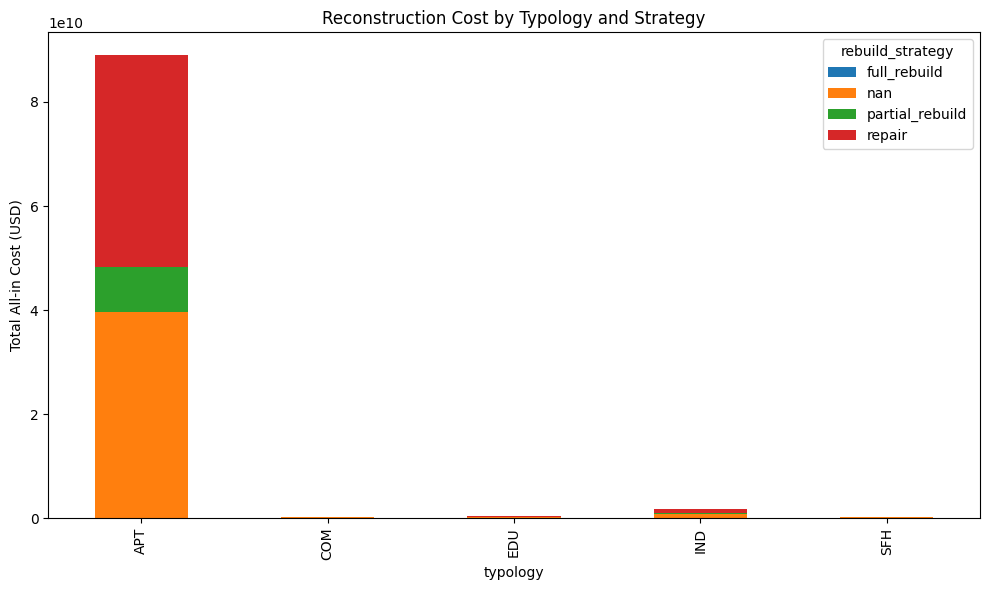

In [ ]:
import matplotlib.pyplot as plt

# Quick bar plot: Total cost by typology and strategy
pivot = summary.pivot(index='typology', columns='rebuild_strategy', values='total_cost_usd')
pivot.plot(kind='bar', stacked=True, figsize=(10,6))
plt.ylabel('Total All-in Cost (USD)')
plt.title('Reconstruction Cost by Typology and Strategy')
plt.tight_layout()
plt.show()

# Section 4. Metaheuristic Urban Optimization for Post-Conflict Gaza

This section describes an improved metaheuristic optimization strategy for reconstructing urban neighborhoods in Gaza using AI-driven, sustainability-focused design principles.

Unlike conventional models that unrealistically overpopulate schools, parks, and religious buildings, our approach prioritizes real-world proportions: 80–90% residential housing, 10–15% community infrastructure (schools, mosques, clinics), and 5–10% open/green spaces. Parks are designed as true green spaces—corridors, plazas, and gardens—integrated with walkability, accessibility, and local cultural patterns.

The optimization integrates debris reuse (transforming former destruction sites into parks or public amenities), maximizes housing, ensures service access, and applies advanced metaheuristic or generative algorithms, all while considering sustainability and the lived realities of Gaza’s urban fabric.

In [ ]:
#@title 1. Data Loading and Preview Template

import pandas as pd
import geopandas as gpd
import numpy as np
import os

from google.colab import drive
drive.mount('/content/drive')

# --- DEFINE DATA DIRECTORY ---
data_dir = '/content/drive/MyDrive/final/'

# --- KEY DATA SOURCES (from your notebook pipeline) ---
PATH_BUILDINGS = data_dir + 'buildings_with_predictions.gpkg'  # All buildings, geometry, features, predicted damage
PATH_BLOCKS = data_dir + 'full_rebuild_blocks_carbon_cost.gpkg'  # Urban blocks, carbon/cost, for advanced layout
PATH_PARKS = data_dir + 'park_candidate_zones_refined.gpkg'  # Candidate park/open space zones
PATH_DEBRIS = data_dir + 'buildings_with_predictions_and_zone_debris.gpkg'  # Buildings + enriched with debris, grid info
PATH_MATERIAL_LOOKUP = data_dir + 'material_lookup.csv'  # Regional archetypes (Egypt, Jordan, Lebanon, Israel), MI/cost
PATH_SUMMARY = data_dir + 'reconstruction_summary_by_typology_strategy.csv'  # Cost/carbon/area summary (optional)
PATH_POP = data_dir + 'SheetJSTableExport (1).xlsx'  # Population/district table (optional)
PATH_BIM_BIC = data_dir + 'forecasted_costs_2025.csv'  # (Optional, only if you want cost model)

# --- LOAD DATA ---
buildings = gpd.read_file(PATH_BUILDINGS)
print(f"Loaded {len(buildings)} buildings from: {PATH_BUILDINGS}")
print(buildings.head(3))

blocks = gpd.read_file(PATH_BLOCKS)
print(f"\nLoaded {len(blocks)} blocks from: {PATH_BLOCKS}")
print(blocks.head(3))

parks = gpd.read_file(PATH_PARKS)
print(f"\nLoaded {len(parks)} park candidate zones from: {PATH_PARKS}")
print(parks.head(3))

debris = gpd.read_file(PATH_DEBRIS)
print(f"\nLoaded {len(debris)} buildings with debris and grid info from: {PATH_DEBRIS}")
print(debris.head(3))

lookup = pd.read_csv(PATH_MATERIAL_LOOKUP)
print(f"\nLoaded regional material lookup table ({lookup.shape[0]} rows): {PATH_MATERIAL_LOOKUP}")
print(lookup.head(3))

if os.path.exists(PATH_SUMMARY):
    summary = pd.read_csv(PATH_SUMMARY)
    print(f"\nLoaded reconstruction summary: {PATH_SUMMARY}")
    print(summary.head(3))

# Population and forecasted costs (optional, skip if not needed for next steps)
if os.path.exists(PATH_POP):
    pop_df = pd.read_excel(PATH_POP, engine='openpyxl')
    print("\nPopulation data by district (first rows):")
    print(pop_df.head(3))
if os.path.exists(PATH_BIM_BIC):
    bim_bic_df = pd.read_csv(PATH_BIM_BIC)
    print("\nLoaded BIM/BIC pricing data (first rows):")
    print(bim_bic_df.head(3))

Mounted at /content/drive
Loaded 335498 buildings from: /content/drive/MyDrive/final/buildings_with_predictions.gpkg
         id addr:city building layer zone  name name:ar name:en  shop amenity  \
0  29684904     Rafah      yes     1   Z1  None    None    None  None    None   
1  29684943     Rafah      yes  None   Z1  None    None    None  None    None   
2  29727198      None      yes  None   Z1  None    None    None  None    None   

   ... opt_ratio_band1 opt_ratio_band5 opt_ratio_band8 sar_diff_band1  \
0  ...        0.802599        0.867705        0.786511      -0.070081   
1  ...        0.892216        0.937951        0.877360       0.324137   
2  ...        0.529831        0.617067        0.707800       1.080373   

  model_pred_class sar_intensity_drop  \
0                2          -0.070081   
1                2           0.324137   
2                1           1.080373   

                        pred_material_type debris_usability  \
0  light material/possible debris or 

In [ ]:
#@title 2. Merge, Filter, and Parameterize Data for Optimization
# SECTION 4, CELL 2: Data Preparation for Urban Metaheuristic Optimization

import pandas as pd
import geopandas as gpd
import numpy as np

# --- LOAD DATA (already loaded in Cell 1, but shown here for clarity) ---
buildings = gpd.read_file('/content/drive/MyDrive/final/buildings_with_predictions_and_zone_debris.gpkg')
lookup = pd.read_csv('/content/drive/MyDrive/final/material_lookup.csv')

# --- FILTER for buildings with geometry and valid typology ---
buildings = buildings[buildings.geometry.notnull()].copy()
# Use provided or derived typology—fall back to regional average ('APT' for most Gaza res. buildings)
if 'typology' not in buildings.columns:
    # Map 'building' or 'building_master' column to typology using lookup/majority
    map_dict = {'apartments': 'APT', 'yes': 'APT', 'house': 'SFH', 'school': 'EDU',
                'mosque': 'COM', 'industrial': 'IND', 'public': 'COM'}
    buildings['typology'] = buildings['building'].map(map_dict).fillna('APT')

# --- SET levels/geometry using available columns or regional averages ---
# Use 'levels' column if present, else fill by typology (from Middle East archetypes)
levels_defaults = {'APT': 5, 'SFH': 2, 'EDU': 3, 'COM': 2, 'IND': 1}
if 'levels' not in buildings.columns:
    buildings['levels'] = buildings['typology'].map(levels_defaults).fillna(3)
else:
    buildings['levels'] = pd.to_numeric(buildings['levels'], errors='coerce').fillna(
        buildings['typology'].map(levels_defaults).fillna(3)
    )
# Set gross floor area (GFA)
buildings['footprint_area_m2'] = buildings.geometry.area
buildings['gross_floor_area_m2'] = buildings['footprint_area_m2'] * buildings['levels']

# --- SET window/door/component counts by regional archetype ---
# Use regional (Middle East) means from PDFs/lookup, fallback if not present
window_defaults = {'APT': 8, 'SFH': 10, 'EDU': 20, 'COM': 12, 'IND': 6}  # Example: adjust based on real data
door_defaults = {'APT': 2, 'SFH': 3, 'EDU': 4, 'COM': 3, 'IND': 2}
buildings['window_count'] = buildings['typology'].map(window_defaults).fillna(8)
buildings['door_count'] = buildings['typology'].map(door_defaults).fillna(2)

# --- USABILITY & DAMAGE: Already encoded as 'model_pred_class' or similar ---
# (Optionally map to usability labels)

# --- DEBRIS, MATERIAL, COST, CARBON: Already in columns or join via lookup ---
for mat in lookup['material'].unique():
    mat_rows = lookup[lookup['material'] == mat]
    for t in mat_rows['typology'].unique():
        sel = (buildings['typology'] == t)
        # Intensity, cost, carbon
        intensity = mat_rows[mat_rows['typology'] == t]['intensity_kg_per_m2'].values[0]
        cost_per_ton = mat_rows[mat_rows['typology'] == t]['unit_cost_usd_per_ton'].values[0]
        carbon_per_m2 = mat_rows[mat_rows['typology'] == t]['carbon_kg_per_m2'].fillna(0).values[0]
        area = buildings.loc[sel, 'gross_floor_area_m2']
        buildings.loc[sel, f'{mat}_kg'] = area * intensity
        buildings.loc[sel, f'{mat}_tons'] = buildings.loc[sel, f'{mat}_kg'] / 1000
        buildings.loc[sel, f'{mat}_cost_usd'] = buildings.loc[sel, f'{mat}_tons'] * cost_per_ton
        buildings.loc[sel, f'{mat}_carbon_kg'] = area * carbon_per_m2

# --- FILL NaN/empty cost/carbon with 0 for safety ---
cost_cols = [col for col in buildings.columns if col.endswith('_cost_usd')]
carbon_cols = [col for col in buildings.columns if col.endswith('_carbon_kg')]
buildings[cost_cols] = buildings[cost_cols].fillna(0)
buildings[carbon_cols] = buildings[carbon_cols].fillna(0)

# --- SUMMARY COLUMNS for OPTIMIZATION ---
buildings['total_material_cost_usd'] = buildings[cost_cols].sum(axis=1)
buildings['total_embodied_carbon_kg'] = buildings[carbon_cols].sum(axis=1)

# --- WINDOWS/DOORS/COMPONENTS (future-proof for more features) ---
component_cols = ['window_count', 'door_count']  # add more as available

# --- OPTIONAL: Save prepared file for optimization (uncomment if desired) ---
# buildings.drop(columns='geometry', errors='ignore').to_csv('/content/drive/MyDrive/final/buildings_prepared_for_optimization.csv', index=False)

# --- PREVIEW MERGED DATA ---
print(buildings[['id', 'typology', 'levels', 'gross_floor_area_m2', 'window_count', 'door_count',
                 'model_pred_class', 'debris_amount_proxy', 'total_material_cost_usd', 'total_embodied_carbon_kg']].head(10))

         id typology  levels  gross_floor_area_m2  window_count  door_count  \
0  29684904      APT       5         35615.307329             8           2   
1  29684904      APT       5         35615.307329             8           2   
2  29684943      APT       5          5910.964481             8           2   
3  29727198      APT       5          4837.858245             8           2   
4  29727198      APT       5          4837.858245             8           2   
5  41312804      APT       5          7448.778946             8           2   
6  41312981      APT       5          3656.380116             8           2   
7  41313259      APT       5          1423.361224             8           2   
8  41313468      APT       5          4973.641142             8           2   
9  41313559      APT       5          9626.518333             8           2   

   model_pred_class  debris_amount_proxy  total_material_cost_usd  \
0                 2             0.070081             8.173713

In [ ]:
#@title 3. Metaheuristic Optimization for Net Zero & Circular Urban Reconstruction

import numpy as np
import pandas as pd
from tqdm import tqdm

# --- SETTINGS ---
RECYCLING_EFFICIENCY = 0.7  # 70% of usable debris can be recycled (adjust per region or strategy)
CARBON_OFFSET_PER_BUILDING = 0  # Target: net zero embodied carbon at city scale
OPERATIONAL_CARBON_PER_M2 = 8  # Example: 8 kgCO2/m2/year (replace with local value if available)
YEARS = 60  # Building lifecycle considered
CARBON_OFFSET_PROJECTS = 0  # Amount of carbon offsets purchased (if any)

# --- OPTIMIZATION LOGIC ---

def assign_reused_material(building_row, debris_col='debris_amount_proxy'):
    # How much debris (proxy for usable recycled material) is available for this building?
    debris = building_row[debris_col]
    typology = building_row['typology']
    area = building_row['gross_floor_area_m2']

    # Estimate total material need (sum all regionally-typical material intensities for this typology)
    needed_kg = 0
    needed_cost = 0
    needed_carbon = 0
    # Use your regional lookup already applied above, but you could sum if more granularity is needed

    # Assume debris covers X% of need, remainder is new
    reuse_ratio = min(RECYCLING_EFFICIENCY * debris, 1.0)  # Cap at 100%
    new_ratio = 1.0 - reuse_ratio

    # Calculate total cost and carbon with recycled/new mix
    total_material_cost = building_row['total_material_cost_usd'] * new_ratio
    total_embodied_carbon = building_row['total_embodied_carbon_kg'] * new_ratio
    # For the reused portion, assume cost drops by 60% and carbon by 80% vs. new
    recycled_cost = building_row['total_material_cost_usd'] * reuse_ratio * 0.4
    recycled_carbon = building_row['total_embodied_carbon_kg'] * reuse_ratio * 0.2
    # Add together
    blended_cost = total_material_cost + recycled_cost
    blended_carbon = total_embodied_carbon + recycled_carbon

    # Calculate operational carbon over lifecycle (net zero constraint applied at summary level)
    operational_carbon = building_row['gross_floor_area_m2'] * OPERATIONAL_CARBON_PER_M2 * YEARS

    return pd.Series({
        'reuse_ratio': reuse_ratio,
        'new_ratio': new_ratio,
        'recycled_material_cost_usd': recycled_cost,
        'new_material_cost_usd': total_material_cost,
        'blended_material_cost_usd': blended_cost,
        'recycled_carbon_kg': recycled_carbon,
        'new_carbon_kg': total_embodied_carbon,
        'blended_embodied_carbon_kg': blended_carbon,
        'operational_carbon_kg': operational_carbon
    })

# --- APPLY OPTIMIZATION PER BUILDING ---
tqdm.pandas()
results = buildings.progress_apply(assign_reused_material, axis=1)

# --- COMBINE RESULTS ---
buildings = pd.concat([buildings, results], axis=1)

# --- CALCULATE URBAN NET ZERO CONSTRAINTS ---
total_blended_carbon = buildings['blended_embodied_carbon_kg'].sum()
total_operational_carbon = buildings['operational_carbon_kg'].sum()
total_urban_carbon = total_blended_carbon + total_operational_carbon - CARBON_OFFSET_PROJECTS

# Print high-level results:
print(f"Total urban embodied carbon (with circularity): {total_blended_carbon:,.0f} kg")
print(f"Total urban operational carbon over {YEARS} years: {total_operational_carbon:,.0f} kg")
print(f"Net total urban carbon: {total_urban_carbon:,.0f} kg")
if total_urban_carbon < 1e-5:
    print(">> Net zero carbon achieved at urban scale!")
else:
    print(">> Net zero carbon not yet achieved. Consider more debris reuse, higher offsets, or efficiency.")

# --- PREVIEW OPTIMIZED DATASET ---
print(buildings[['id', 'typology', 'gross_floor_area_m2', 'reuse_ratio', 'blended_material_cost_usd',
                 'blended_embodied_carbon_kg', 'operational_carbon_kg']].head(10))

# --- OPTIONAL: Save for GIS or further analysis
# buildings.to_file('/content/drive/MyDrive/final/buildings_optimized_netzero.gpkg', driver='GPKG')


100%|██████████| 378370/378370 [01:13<00:00, 5169.32it/s]


Total urban embodied carbon (with circularity): 122,434,498,188 kg
Total urban operational carbon over 60 years: 172,206,608,037 kg
Net total urban carbon: 294,641,106,224 kg
>> Net zero carbon not yet achieved. Consider more debris reuse, higher offsets, or efficiency.
         id typology  gross_floor_area_m2  reuse_ratio  \
0  29684904      APT         35615.307329     0.049057   
1  29684904      APT         35615.307329     0.049057   
2  29684943      APT          5910.964481     0.226896   
3  29727198      APT          4837.858245     0.756261   
4  29727198      APT          4837.858245     0.756261   
5  41312804      APT          7448.778946     0.461265   
6  41312981      APT          3656.380116     1.000000   
7  41313259      APT          1423.361224     0.885362   
8  41313468      APT          4973.641142     0.418216   
9  41313559      APT          9626.518333     0.538211   

   blended_material_cost_usd  blended_embodied_carbon_kg  \
0               7.933126e+06  

In [ ]:
#@title 4.a Prepare Feature Table for Training (and Prediction)
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Polygon
from google.colab import drive
drive.mount('/content/drive')

lookup = pd.read_csv('/content/drive/MyDrive/final/master_archetypes_optimized.csv')
buildings = gpd.read_file('/content/drive/MyDrive/final/buildings_with_predictions_and_zone_debris.gpkg')
parks = gpd.read_file('/content/drive/MyDrive/final/park_candidate_zones_refined.gpkg')

# Robust area assignment
def get_area(row):
    area = row.get('area', None)
    if area is None or pd.isnull(area) or area == 0:
        try:
            area = row.geometry.area
        except Exception:
            area = 1.0  # Fallback: 1 m2 if geometry is missing
    return float(area)

buildings['area'] = buildings.apply(get_area, axis=1)

# Now safe to assign typology
def auto_typology(row):
    area = row['area']
    bldg_type = str(row['building']).lower() if 'building' in row else ''
    # Add robust logic for all cases
    if area < 60:
        return 'SFH'
    elif area < 250:
        return 'APT'
    elif area < 600:
        return 'MIDRISE'
    elif area < 1200:
        return 'HIGHRISE'
    elif 'school' in bldg_type:
        return 'SCHOOL'
    elif 'hospital' in bldg_type:
        return 'HOSPITAL'
    elif 'industrial' in bldg_type:
        return 'IND'
    elif 'mosque' in bldg_type:
        return 'MOSQUE'
    elif 'public' in bldg_type:
        return 'PUBLIC'
    else:
        return 'COM'

buildings['auto_typology'] = buildings.apply(auto_typology, axis=1)

# --- Map to archetype typologies ---
def map_archetype_typology(auto_typ):
    archetype_map = {
        'MIDRISE': 'APT',
        'HIGHRISE': 'APT',
        'PUBLIC': 'COM',
        'MOSQUE': 'COM',
        'SCHOOL': 'EDU',
        'HOSPITAL': 'EDU'
    }
    return archetype_map.get(auto_typ, auto_typ)

buildings['archetype_typology'] = buildings['auto_typology'].apply(map_archetype_typology)

# Nearest park calculation (unchanged)
parks_xy = np.array([geom.centroid.coords[0] for geom in parks.geometry])
building_centroids = np.array([geom.centroid.coords[0] for geom in buildings.geometry])
from sklearn.neighbors import BallTree
parks_tree = BallTree(parks_xy, metric='euclidean')
dist, _ = parks_tree.query(building_centroids, k=1)
buildings['nearest_park_m'] = dist

print(buildings[['id','auto_typology','archetype_typology','building','area','nearest_park_m']].head(10))

Mounted at /content/drive
         id auto_typology archetype_typology    building         area  \
0  29684904           COM                COM         yes  7123.061466   
1  29684904           COM                COM         yes  7123.061466   
2  29684943      HIGHRISE                APT         yes  1182.192896   
3  29727198      HIGHRISE                APT         yes   967.571649   
4  29727198      HIGHRISE                APT         yes   967.571649   
5  41312804           COM                COM         yes  1489.755789   
6  41312981      HIGHRISE                APT         yes   731.276023   
7  41313259       MIDRISE                APT         yes   284.672245   
8  41313468      HIGHRISE                APT  apartments   994.728228   
9  41313559           COM                COM         yes  1925.303667   

   nearest_park_m  
0    3.198313e+06  
1    3.198313e+06  
2    3.198376e+06  
3    3.198280e+06  
4    3.198280e+06  
5    3.198296e+06  
6    3.197711e+06  
7    3.197

In [ ]:
#@title 4.b Assign Proportional Elements (Floors, Windows, Doors) - Preserving All Columns
def fill_elements(row):
    match = lookup[
        (lookup['typology'] == row['archetype_typology']) &
        (lookup['country'] == 'Gaza') &
        (lookup['material'] == 'concrete')
    ]
    if match.empty:
        match = lookup[(lookup['typology'] == row['archetype_typology']) & (lookup['material'] == 'concrete')]
    if match.empty:
        match = lookup[(lookup['typology'] == 'APT') & (lookup['material'] == 'concrete')]
    arch = match.iloc[0]

    if row['auto_typology'] == 'MIDRISE':
        levels = min(max(arch['floor_min'] + 2, 4), arch['floor_max'])
    elif row['auto_typology'] == 'HIGHRISE':
        levels = arch['floor_max'] + 2
    else:
        levels = np.random.randint(arch['floor_min'], arch['floor_max'] + 1)
    area = row['area']
    win = max(int((area * levels) // 25), arch['window_count'])
    door = max(int(area // 60), arch['door_count'])
    return pd.Series({
        'levels_opt': levels,
        'window_count_opt': win,
        'door_count_opt': door
    })

elements = buildings.apply(fill_elements, axis=1)
buildings = pd.concat([buildings, elements], axis=1)

# Preview for traceability
print(buildings[['id','auto_typology','archetype_typology','levels_opt','window_count_opt','door_count_opt']].head(12))


          id auto_typology archetype_typology  levels_opt  window_count_opt  \
0   29684904           COM                COM           4              1139   
1   29684904           COM                COM           4              1139   
2   29684943      HIGHRISE                APT           8               378   
3   29727198      HIGHRISE                APT           8               309   
4   29727198      HIGHRISE                APT           8               309   
5   41312804           COM                COM           5               297   
6   41312981      HIGHRISE                APT           8               234   
7   41313259       MIDRISE                APT           6                68   
8   41313468      HIGHRISE                APT           8               318   
9   41313559           COM                COM           6               462   
10  41313792      HIGHRISE                APT           8               214   
11  41313931           APT                APT       

In [ ]:
#@title 4.c Candidate Generation with Rebuild Strategy, Debris Limits
# Make sure you have 'rebuild_strategy', 'usable_recycled_tons', etc. in your buildings df!
OPERATIONAL_CARBON_PER_M2 = 8
YEARS = 60
TARGET_WALK_DIST = 1000
reuse_grid = np.linspace(0, 1, 5)  # (adjust granularity as needed)

def safe_val(row, col, arch_val):
    vals = []
    for c in buildings.columns[::-1]:
        if c.startswith(col):
            v = row[c]
            try:
                v = float(v)
            except:
                v = np.nan
            if not pd.isnull(v) and v > 0:
                return int(v)
    return int(arch_val)

all_samples = []

for idx, row in buildings.iterrows():
    typology = row['archetype_typology']
    area = float(row['area'])
    levels = int(row['levels_opt'])
    window_count = int(row['window_count_opt'])
    door_count = int(row['door_count_opt'])
    nearest_park_m = float(row['nearest_park_m'])
    strategy = row.get('rebuild_strategy', 'full_rebuild')
    debris_limit = row.get('usable_recycled_tons', np.nan)
    match = lookup[
        (lookup['typology'] == typology) &
        (lookup['country'] == 'Gaza') &
        (lookup['material'] == 'concrete')
    ]
    if match.empty:
        match = lookup[(lookup['typology'] == typology) & (lookup['material'] == 'concrete')]
    if match.empty:
        match = lookup[(lookup['typology'] == 'APT') & (lookup['material'] == 'concrete')]
    if match.empty:
        continue

    arch = match.iloc[0]
    intensity = arch['intensity_kg_per_m2']
    cost_per_ton = arch['unit_cost_usd_per_ton']
    carbon_per_m2 = arch['carbon_kg_per_m2']

    # Set max reuse ratio realistically: at most what debris is available
    max_reuse_ratio = 1.0
    if not pd.isnull(debris_limit) and debris_limit > 0:
        total_material_mass = (intensity * area * levels) / 1000  # tons
        max_reuse_ratio = min(1.0, debris_limit / total_material_mass)
        max_reuse_ratio = max(0.0, max_reuse_ratio)  # Never negative

    for reuse_ratio in [r for r in reuse_grid if r <= max_reuse_ratio]:
        # Cost/Carbon logic by strategy
        if strategy == 'repair':
            cost_factor = 0.3  # Example: repair is 30% of new
            carbon_factor = 0.2
        elif strategy == 'partial_rebuild':
            cost_factor = 0.7
            carbon_factor = 0.5
        else:  # 'full_rebuild' or missing
            cost_factor = 1.0
            carbon_factor = 1.0

        mat_cost = (intensity * area * levels / 1000) * cost_per_ton * cost_factor
        mat_carbon = area * levels * carbon_per_m2 * carbon_factor
        total_cost = mat_cost * (1 - reuse_ratio) + mat_cost * reuse_ratio * 0.4
        total_carbon = mat_carbon * (1 - reuse_ratio) + mat_carbon * reuse_ratio * 0.2
        total_cost += window_count * 200 + door_count * 400
        operational_carbon = area * levels * OPERATIONAL_CARBON_PER_M2 * YEARS
        total_carbon += operational_carbon
        walk_penalty = 0 if nearest_park_m <= TARGET_WALK_DIST else (nearest_park_m - TARGET_WALK_DIST)
        all_samples.append({
            'id': row['id'],
            'auto_typology': row['auto_typology'],
            'archetype_typology': typology,
            'levels_opt': levels,
            'window_count_opt': window_count,
            'door_count_opt': door_count,
            'area': area,
            'rebuild_strategy': strategy,
            'usable_recycled_tons': debris_limit,
            'reuse_ratio': reuse_ratio,
            'nearest_park_m': nearest_park_m,
            'cost': total_cost,
            'carbon': total_carbon,
            'walk_penalty': walk_penalty,
        })

train_df = pd.DataFrame(all_samples)
print(train_df.head(10))
print("Columns in training DataFrame:", train_df.columns.tolist())
print(f"Total candidate samples generated: {len(train_df)}")

/tmp/ipython-input-4-1779284034.py:53: RuntimeWarning: divide by zero encountered in scalar divide
  max_reuse_ratio = min(1.0, debris_limit / total_material_mass)


         id auto_typology archetype_typology  levels_opt  window_count_opt  \
0  29684904           COM                COM           4              1139   
1  29684904           COM                COM           4              1139   
2  29684904           COM                COM           4              1139   
3  29684904           COM                COM           4              1139   
4  29684904           COM                COM           4              1139   
5  29684904           COM                COM           4              1139   
6  29684943      HIGHRISE                APT           8               378   
7  29727198      HIGHRISE                APT           8               309   
8  29727198      HIGHRISE                APT           8               309   
9  29727198      HIGHRISE                APT           8               309   

   door_count_opt         area rebuild_strategy  usable_recycled_tons  \
0             118  7123.061466              nan              0.00000

In [ ]:
#@title 4.d ML Model Training and Inference (XGBoost, per-objective)
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score

# Encode typology as integer
train_df['typology_enc'] = LabelEncoder().fit_transform(train_df['archetype_typology'])

# Prepare features and targets
features = [
    'typology_enc',
    'area',
    'levels_opt',
    'window_count_opt',
    'door_count_opt',
    'reuse_ratio',
    'nearest_park_m'
]

X = train_df[features]
y_cost = train_df['cost']
y_carbon = train_df['carbon']
y_walk = train_df['walk_penalty']

# Split for validation
X_train, X_test, y_cost_train, y_cost_test = train_test_split(X, y_cost, test_size=0.2, random_state=42)
X_train, X_test, y_carbon_train, y_carbon_test = train_test_split(X, y_carbon, test_size=0.2, random_state=42)
X_train, X_test, y_walk_train, y_walk_test = train_test_split(X, y_walk, test_size=0.2, random_state=42)

# Train models
cost_model = xgb.XGBRegressor(n_estimators=100, max_depth=6, n_jobs=-1)
carbon_model = xgb.XGBRegressor(n_estimators=100, max_depth=6, n_jobs=-1)
walk_model = xgb.XGBRegressor(n_estimators=100, max_depth=6, n_jobs=-1)

cost_model.fit(X_train, y_cost_train)
carbon_model.fit(X_train, y_carbon_train)
walk_model.fit(X_train, y_walk_train)

# Validation: Print MAE and R^2
print("\n--- Model Validation ---")
print("Cost MAE:", mean_absolute_error(y_cost_test, cost_model.predict(X_test)))
print("Carbon MAE:", mean_absolute_error(y_carbon_test, carbon_model.predict(X_test)))
print("Walk Penalty MAE:", mean_absolute_error(y_walk_test, walk_model.predict(X_test)))
print("Cost R2:", r2_score(y_cost_test, cost_model.predict(X_test)))
print("Carbon R2:", r2_score(y_carbon_test, carbon_model.predict(X_test)))
print("Walk Penalty R2:", r2_score(y_walk_test, walk_model.predict(X_test)))

# Show predictions for first few examples
preds = cost_model.predict(X_test[:10])
print("\nSample predicted costs:", preds)
print("Actual costs:", y_cost_test.iloc[:10].values)


--- Model Validation ---
Cost MAE: 15080.30336830053
Carbon MAE: 75119.10732886383
Walk Penalty MAE: 30.84196082445932
Cost R2: 0.9587334372417131
Carbon R2: 0.988071171418303
Walk Penalty R2: 0.9999754188720068

Sample predicted costs: [ 33798.3      6555.864   28983.625    5425.0254 118768.94     5466.068
  28334.174   18200.643    5514.829   82542.28  ]
Actual costs: [ 39469.77365099   4659.1630096   18234.69294989   4952.57896686
 137744.7814521    4387.28173894  15936.84951517  37309.87133611
   4396.80429151  50294.97334081]


In [ ]:
import joblib

joblib.dump(cost_model, '/content/drive/MyDrive/final/urban_cost_model_xgb.pkl')
joblib.dump(carbon_model, '/content/drive/MyDrive/final/urban_carbon_model_xgb.pkl')
joblib.dump(walk_model, '/content/drive/MyDrive/final/urban_walk_model_xgb.pkl')

print("Models saved to your Drive in /content/drive/MyDrive/final/")

Models saved to your Drive in /content/drive/MyDrive/final/


In [ ]:
#@title 4.e ML-Driven Citywide Optimal Assignment
import joblib
import numpy as np
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder

cost_model = joblib.load('/content/drive/MyDrive/final/urban_cost_model_xgb.pkl')
carbon_model = joblib.load('/content/drive/MyDrive/final/urban_carbon_model_xgb.pkl')
walk_model = joblib.load('/content/drive/MyDrive/final/urban_walk_model_xgb.pkl')

all_typologies = pd.Series(
    pd.concat([
        train_df['archetype_typology'],
        buildings['archetype_typology']
    ])
).unique()
typ_enc = LabelEncoder().fit(all_typologies)

reuse_grid = np.linspace(0, 1, 5)

def get_last_numeric(row, col_stem):
    cols = [c for c in row.index if c.startswith(col_stem)]
    for c in cols[::-1]:
        val = row[c]
        try:
            valf = float(val)
            if not np.isnan(valf) and valf > 0:
                return int(valf)
        except:
            continue
    return 0

results = []
missing_types = set()

for idx, row in tqdm(buildings.iterrows(), total=len(buildings)):
    typology = row['archetype_typology']
    area = float(row['area'])
    levels = int(row['levels_opt'])
    window_count = int(row['window_count_opt'])
    door_count = int(row['door_count_opt'])
    nearest_park_m = float(row['nearest_park_m'])
    debris_limit = row.get('usable_recycled_tons', np.nan)
    strategy = row.get('rebuild_strategy', 'full_rebuild')
    max_reuse_ratio = 1.0
    if not pd.isnull(debris_limit) and debris_limit > 0:
        match = lookup[
            (lookup['typology'] == typology) &
            (lookup['country'] == 'Gaza') &
            (lookup['material'] == 'concrete')
        ]
        if match.empty:
            match = lookup[(lookup['typology'] == typology) & (lookup['material'] == 'concrete')]
        if match.empty:
            match = lookup[(lookup['typology'] == 'APT') & (lookup['material'] == 'concrete')]
        arch = match.iloc[0]
        total_material_mass = (arch['intensity_kg_per_m2'] * area * levels) / 1000  # tons
        max_reuse_ratio = min(1.0, debris_limit / total_material_mass)
        max_reuse_ratio = max(0.0, max_reuse_ratio)
    if typology not in typ_enc.classes_:
        if typology not in missing_types:
            print(f"Skipping building with unknown typology: {typology}")
            missing_types.add(typology)
        continue
    best_score = np.inf
    best_config = None
    for reuse_ratio in [r for r in reuse_grid if r <= max_reuse_ratio]:
        x = np.array([[typ_enc.transform([typology])[0], area, levels, window_count, door_count, reuse_ratio, nearest_park_m]])
        pred_cost = cost_model.predict(x)[0]
        pred_carbon = carbon_model.predict(x)[0]
        pred_walk = walk_model.predict(x)[0]
        score = pred_cost + pred_carbon * 0.5 + pred_walk * 1000
        if score < best_score:
            best_score = score
            best_config = {
                'id': row['id'],
                'auto_typology': row['auto_typology'],
                'archetype_typology': typology,
                'levels_opt': levels,
                'window_count_opt': window_count,
                'door_count_opt': door_count,
                'area': area,
                'rebuild_strategy': strategy,
                'usable_recycled_tons': debris_limit,
                'reuse_ratio': reuse_ratio,
                'nearest_park_m': nearest_park_m,
                'pred_cost': pred_cost,
                'pred_carbon': pred_carbon,
                'pred_walk': pred_walk,
                'score': score
            }
    if best_config is not None:
        results.append(best_config)

optimal_df = pd.DataFrame(results)
buildings_optimized = buildings.merge(optimal_df, on='id', suffixes=('', '_opt'))

# Don't drop anything! Explicitly keep all optimal and all original columns.
buildings_optimized.to_file('/content/drive/MyDrive/final/buildings_urban_optimized_ml_xgb.gpkg', driver='GPKG')
print("ML-optimized citywide assignment (with all details) saved to: buildings_urban_optimized_ml_xgb.gpkg")


 93%|█████████▎| 351619/378370 [52:18<11:27, 38.89it/s]/tmp/ipython-input-8-2639277799.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  max_reuse_ratio = min(1.0, debris_limit / total_material_mass)
100%|██████████| 378370/378370 [56:15<00:00, 112.08it/s]


ML-optimized citywide assignment (with all details) saved to: buildings_urban_optimized_ml_xgb.gpkg


In [ ]:
cols_to_keep = [
    'id', 'auto_typology', 'archetype_typology', 'levels_opt', 'window_count_opt', 'door_count_opt',
    'area', 'rebuild_strategy', 'usable_recycled_tons', 'reuse_ratio', 'nearest_park_m',
    'pred_cost', 'pred_carbon', 'pred_walk', 'score', 'geometry'
]
buildings_optimized[cols_to_keep].to_file('/content/drive/MyDrive/final/buildings_urban_optimized_ml_xgb.geojson', driver='GeoJSON')

In [ ]:
# Save the buildings_optimized GeoDataFrame to a CSV file (excluding geometry)
csv_cols_to_keep = [
    'id', 'auto_typology', 'archetype_typology', 'levels_opt', 'window_count_opt', 'door_count_opt',
    'area', 'rebuild_strategy', 'usable_recycled_tons', 'reuse_ratio', 'nearest_park_m',
    'pred_cost', 'pred_carbon', 'pred_walk', 'score'
]

# Ensure all columns to keep exist in the DataFrame
csv_cols_to_keep = [col for col in csv_cols_to_keep if col in buildings_optimized.columns]

buildings_optimized[csv_cols_to_keep].to_csv('/content/drive/MyDrive/final/buildings_urban_optimized_ml_xgb.csv', index=False)

print("CSV version of buildings_urban_optimized_ml_xgb saved to /content/drive/MyDrive/final/")

CSV version of buildings_urban_optimized_ml_xgb saved to /content/drive/MyDrive/final/


In [ ]:
import geopandas as gpd

gdf = gpd.read_file("/content/drive/MyDrive/final/buildings_urban_optimized_ml_xgb.geojson")

# Reproject to WGS84 (EPSG:4326)
gdf = gdf.to_crs("EPSG:4326")

# Save corrected version
gdf.to_file("buildings_reprojected.geojson", driver="GeoJSON")

/usr/local/lib/python3.11/dist-packages/pyogrio/raw.py:198: RuntimeWarning: Several features with id = 29684904 have been found. Altering it to be unique. This warning will not be emitted anymore for this layer
  return ogr_read(


In [ ]:
#@title 5. Preview and analyze the GeoPackage
import geopandas as gpd
import pandas as pd

# Load the saved optimized GeoPackage
gdf = gpd.read_file('/content/drive/MyDrive/final/buildings_urban_optimized_ml_xgb.gpkg')

print("\n==== Columns in GeoPackage ====\n", gdf.columns.tolist())

# Print first 5 rows
print("\n==== First 5 Rows ====\n", gdf.head())

# Print summary statistics for key optimized fields
print("\n==== Key Field Summary ====")
fields = ['archetype_typology', 'levels', 'window_count', 'door_count', 'reuse_ratio',
          'pred_cost', 'pred_carbon', 'pred_walk', 'score']
for field in fields:
    if field in gdf.columns:
        print(f"\nSummary for {field}:")
        print(gdf[field].describe())
    else:
        # In case columns were renamed or have suffixes, try to match
        matches = [c for c in gdf.columns if c.startswith(field)]
        if matches:
            print(f"\nSummary for {matches[0]}:")
            print(gdf[matches[0]].describe())

# Print value counts for typology and optimal reuse_ratio
print("\n==== Typology Counts ====")
if 'archetype_typology' in gdf.columns:
    print(gdf['archetype_typology'].value_counts())
elif 'archetype_typology_opt' in gdf.columns:
    print(gdf['archetype_typology_opt'].value_counts())

print("\n==== Optimal Reuse Ratio Distribution ====")
reuse_col = 'reuse_ratio'
if 'reuse_ratio' not in gdf.columns:
    reuse_col = [c for c in gdf.columns if c.startswith('reuse_ratio')][0]
print(gdf[reuse_col].value_counts().sort_index())

# Print cost and carbon totals
if 'pred_cost' in gdf.columns and 'pred_carbon' in gdf.columns:
    print(f"\nTotal optimized cost: {gdf['pred_cost'].sum():,.0f} USD")
    print(f"Total optimized embodied + operational carbon: {gdf['pred_carbon'].sum():,.0f} kg")

print("\nAnalysis complete.")



==== Columns in GeoPackage ====
 ['id', 'addr:city', 'building', 'layer', 'zone', 'name', 'name:ar', 'name:en', 'shop', 'amenity', 'healthcare', 'source', 'leisure', 'sport', 'denomination', 'religion', 'operator', 'content', 'man_made', 'name:ja', 'barrier', 'name:he', 'addr:street', 'cuisine', 'internet_access', 'opening_hours', 'phone', 'website', 'tourism', 'alt_name', 'was:building', 'name:en1', 'name:tr', 'wall', 'addr:housenumber', 'building:levels', 'height', 'addr:postcode', 'construction', 'craft', 'natural', 'water', 'wikidata', 'wikipedia', 'townhall:type', 'fixme', 'contact:mobile', 'note', 'service_times', 'source:school', 'club', 'email', 'dispensing', 'generator:method', 'generator:output:electricity', 'generator:source', 'generator:type', 'location', 'power', 'cooling:method', 'office', 'name:pt', 'ruins', 'military', 'bunker_type', 'description', 'description:he', 'image', 'image1', 'source:amenity', 'abandoned:aeroway', 'wikipedia:en', 'damage:date', 'damage:event:w

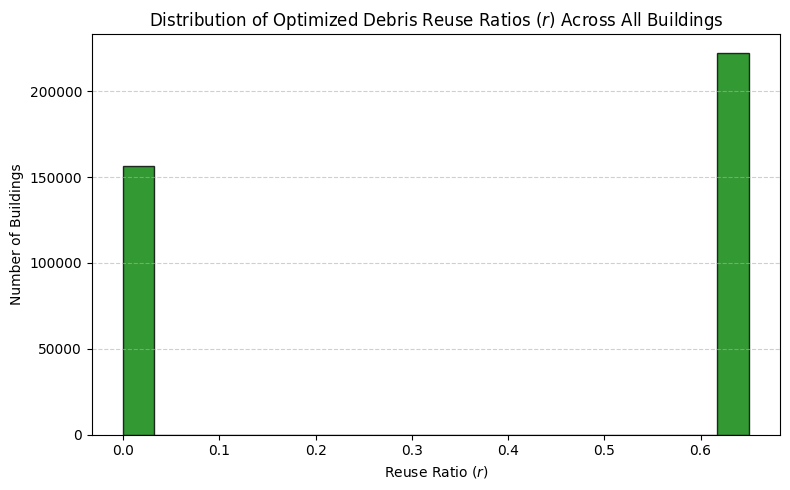

In [ ]:
import matplotlib.pyplot as plt

# Convert to numeric (handles possible non-numeric/NaN gracefully)
reuse_col = 'circularity_score'
reuse_values = pd.to_numeric(buildings[reuse_col], errors='coerce')

plt.figure(figsize=(8, 5))
plt.hist(reuse_values.dropna(), bins=20, color='green', edgecolor='black', alpha=0.8)
plt.title('Distribution of Optimized Debris Reuse Ratios ($r$) Across All Buildings')
plt.xlabel('Reuse Ratio ($r$)')
plt.ylabel('Number of Buildings')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig('reuse_ratio_histogram.png', dpi=300)
plt.show()


# Section 5. Cost Prediction and  Rendering for current setup
Data set represent all structures that are standing, restorable, or part of the optimal recovery map.

In [ ]:
import pandas as pd
import numpy as np

# --- Load data ---
buildings = pd.read_csv('/content/drive/MyDrive/final/buildings_urban_optimized_ml_xgb.csv')
archetypes = pd.read_csv('/content/drive/MyDrive/final/archetype_material_costs_master_full.csv')

# --- Standardize/ensure columns exist and fill NaNs ---
if 'area_opt' in buildings.columns:
    buildings['area'] = buildings['area_opt']
elif 'area' in buildings.columns:
    buildings['area'] = buildings['area']
else:
    raise ValueError("No area or area_opt column in buildings dataset!")

buildings['area'] = buildings['area'].fillna(0)

# Use correct column for recycled tons
if 'usable_recycled_tons_opt' in buildings.columns:
    buildings['recycled_tons'] = buildings['usable_recycled_tons_opt']
elif 'usable_recycled_tons' in buildings.columns:
    buildings['recycled_tons'] = buildings['usable_recycled_tons']
else:
    buildings['recycled_tons'] = 0
buildings['recycled_tons'] = buildings['recycled_tons'].fillna(0)

if 'reuse_ratio' not in buildings.columns:
    buildings['reuse_ratio'] = 0
buildings['reuse_ratio'] = buildings['reuse_ratio'].fillna(0)

# Match typology column
if 'archetype_typology_opt' in buildings.columns:
    buildings['typology'] = buildings['archetype_typology_opt']
else:
    buildings['typology'] = buildings['archetype_typology']

# --- Assign "full_rebuild" to all buildings with missing or non-existent strategy ---
if 'rebuild_strategy' not in buildings.columns:
    buildings['rebuild_strategy'] = 'full_rebuild'
else:
    buildings['rebuild_strategy'] = buildings['rebuild_strategy'].fillna('full_rebuild')

materials = archetypes['material'].unique()

# --- Get ROUNDED AVERAGE MI and prices per typology (across all countries) ---
typ_mat = archetypes.groupby(['typology', 'material']).agg({
    'mi_ton_per_m2': 'mean',
    'unit_price_usd_per_ton': 'mean',
    'markup': 'mean',
    'price_usd_per_ton_inflated': 'mean'
}).reset_index()

typ_mat['mi_ton_per_m2'] = np.ceil(typ_mat['mi_ton_per_m2'] * 1000) / 1000
typ_mat['unit_price_usd_per_ton'] = np.ceil(typ_mat['unit_price_usd_per_ton'])
typ_mat['price_usd_per_ton_inflated'] = np.ceil(typ_mat['price_usd_per_ton_inflated'])

typ_mi_dict = typ_mat.set_index(['typology','material'])['mi_ton_per_m2'].to_dict()
typ_price_dict = typ_mat.set_index(['typology','material'])['unit_price_usd_per_ton'].to_dict()
typ_price_infl_dict = typ_mat.set_index(['typology','material'])['price_usd_per_ton_inflated'].to_dict()

# --- Compute per-building material costs ---
for mat in materials:
    mi = buildings['typology'].apply(lambda typ: typ_mi_dict.get((typ, mat), 0))
    unit_price = buildings['typology'].apply(lambda typ: typ_price_dict.get((typ, mat), 0))
    price_infl = buildings['typology'].apply(lambda typ: typ_price_infl_dict.get((typ, mat), 0))
    tons_needed = buildings['area'] * mi
    # Debris recycling: only reduce new material if reuse_ratio > 0
    recycled = np.where(buildings['reuse_ratio'] > 0, buildings['recycled_tons'], 0)
    net_new_tons = np.maximum(tons_needed - recycled, 0)
    buildings[f"{mat}_tons"] = net_new_tons
    buildings[f"{mat}_cost_pre"] = net_new_tons * unit_price
    buildings[f"{mat}_cost_infl"] = net_new_tons * price_infl

# --- Doors & Windows (actual per-building counts, with real markups from docs) ---
DOOR_UNIT_COST = 150
DOOR_MARKUP = 5
WINDOW_UNIT_COST = 90
WINDOW_MARKUP = 6
buildings['door_count'] = buildings['door_count_opt'] if 'door_count_opt' in buildings.columns else 0
buildings['window_count'] = buildings['window_count_opt'] if 'window_count_opt' in buildings.columns else 0
buildings['door_cost_pre'] = buildings['door_count'] * DOOR_UNIT_COST
buildings['door_cost_infl'] = buildings['door_count'] * DOOR_UNIT_COST * DOOR_MARKUP
buildings['window_cost_pre'] = buildings['window_count'] * WINDOW_UNIT_COST
buildings['window_cost_infl'] = buildings['window_count'] * WINDOW_UNIT_COST * WINDOW_MARKUP

mat_pre = [f"{m}_cost_pre" for m in materials]
mat_infl = [f"{m}_cost_infl" for m in materials]
buildings['total_material_cost_pre'] = buildings[mat_pre].sum(axis=1)
buildings['total_material_cost_infl'] = buildings[mat_infl].sum(axis=1)
buildings['total_cost_pre'] = buildings['total_material_cost_pre'] + buildings['door_cost_pre'] + buildings['window_cost_pre']
buildings['total_cost_infl'] = buildings['total_material_cost_infl'] + buildings['door_cost_infl'] + buildings['window_cost_infl']

cols_out = ['id', 'typology', 'rebuild_strategy', 'area', 'levels_opt', 'reuse_ratio', 'recycled_tons', 'door_count', 'window_count'] \
    + mat_pre + mat_infl + ['door_cost_pre', 'door_cost_infl', 'window_cost_pre', 'window_cost_infl', 'total_cost_pre', 'total_cost_infl']

buildings[cols_out].to_csv('/content/drive/MyDrive/final/buildings_costs_with_and_without_inflation.csv', index=False)
print(buildings[cols_out].head(10))

# === SUMMARY: Per typology, strategy, and material (new/recycled tons, cost) ===

summary = []
for (typ, strat) in buildings.groupby(['typology', 'rebuild_strategy']).groups:
    bldgs_typ = buildings[(buildings['typology'] == typ) & (buildings['rebuild_strategy'] == strat)]
    total_recycled = bldgs_typ['recycled_tons'].sum()
    for mat in materials:
        tons_col = f"{mat}_tons"
        pre_col = f"{mat}_cost_pre"
        infl_col = f"{mat}_cost_infl"
        total_new = bldgs_typ[tons_col].sum()
        cost_pre = bldgs_typ[pre_col].sum()
        cost_infl = bldgs_typ[infl_col].sum()
        summary.append({
            'typology': typ,
            'rebuild_strategy': strat,
            'material': mat,
            'total_new_material_tons': total_new,
            'total_recycled_material_tons': total_recycled,
            'cost_pre': cost_pre,
            'cost_infl': cost_infl
        })

summary_df = pd.DataFrame(summary)

pivot = summary_df.groupby(['typology', 'rebuild_strategy']).agg(
    total_new_material_tons = ('total_new_material_tons', 'sum'),
    total_recycled_material_tons = ('total_recycled_material_tons', 'mean'),
    total_cost_pre = ('cost_pre', 'sum'),
    total_cost_infl = ('cost_infl', 'sum')
)
pivot['recycled_share'] = pivot['total_recycled_material_tons'] / (pivot['total_recycled_material_tons'] + pivot['total_new_material_tons'])

# Save both tables
summary_df.to_csv('/content/drive/MyDrive/final/buildings_material_recycling_and_cost_by_typology_and_strategy.csv', index=False)
pivot.to_csv('/content/drive/MyDrive/final/buildings_material_totals_by_typology_and_strategy.csv')

print("\nPer typology, strategy, and material:")
print(summary_df.head(15))
print("\nPer typology and strategy, total recycled and new material and cost:")
print(pivot)


         id typology rebuild_strategy         area  levels_opt  reuse_ratio  \
0  29684904      COM     full_rebuild  7123.061466           4          1.0   
1  29684904      COM     full_rebuild  7123.061466           4          0.0   
2  29684904      COM           repair  7123.061466           4          1.0   
3  29684904      COM           repair  7123.061466           4          0.0   
4  29684943      APT           repair  1182.192896           8          0.0   
5  29727198      APT           repair   967.571649           8          1.0   
6  29727198      APT           repair   967.571649           8          1.0   
7  29727198      APT           repair   967.571649           8          1.0   
8  29727198      APT           repair   967.571649           8          1.0   
9  41312804      COM           repair  1489.755789           5          1.0   

   recycled_tons  door_count  window_count  cement_cost_pre  ...  \
0       0.000000         118          1139    388919.156038  .

In [ ]:
import pandas as pd

# Calculate totals (combined, all buildings)
total_cost_pre = buildings['total_cost_pre'].sum()
total_cost_infl = buildings['total_cost_infl'].sum()

print(f"TOTAL COST before inflation (all buildings): ${total_cost_pre:,.0f}")
print(f"TOTAL COST after inflation (all buildings):  ${total_cost_infl:,.0f}\n")

# Calculate totals by typology
summary_typology = (
    buildings.groupby('typology')[['total_cost_pre', 'total_cost_infl']]
    .sum()
    .sort_values('total_cost_infl', ascending=False)
    .reset_index()
)

# Print as table
print("Total cost by typology:")
print(summary_typology)

TOTAL COST before inflation (all buildings): $9,921,122,642
TOTAL COST after inflation (all buildings):  $30,385,544,292

Total cost by typology:
  typology  total_cost_pre  total_cost_infl
0      COM    7.551953e+09     1.845187e+10
1      APT    1.641091e+09     9.680923e+09
2      SFH    4.028449e+08     1.494683e+09
3      IND    2.769158e+08     6.405360e+08
4      EDU    4.831757e+07     1.175287e+08


In [ ]:
BASE_LABOR_NIS_PER_M2 = 120  # Example: base labor cost per m² for base year
CCI_INDEX_2024 = 149.29      # From your table
ACTUAL_LABOR_NIS_PER_M2 = BASE_LABOR_NIS_PER_M2 * (CCI_INDEX_2024 / 100)

buildings['labor_cost_nis'] = buildings['area'] * ACTUAL_LABOR_NIS_PER_M2
NIS_to_USD = 0.27
buildings['labor_cost_usd'] = buildings['labor_cost_nis'] * NIS_to_USD

buildings['total_cost_pre_with_labor'] = buildings['total_cost_pre'] + buildings['labor_cost_usd']
buildings['total_cost_infl_with_labor'] = buildings['total_cost_infl'] + buildings['labor_cost_usd']

print(buildings[['id', 'typology', 'area', 'labor_cost_nis', 'labor_cost_usd', 'total_cost_pre_with_labor', 'total_cost_infl_with_labor']].head(10))


         id typology         area  labor_cost_nis  labor_cost_usd  \
0  29684904      COM  7123.061466    1.276082e+06   344542.198183   
1  29684904      COM  7123.061466    1.276082e+06   344542.198183   
2  29684904      COM  7123.061466    1.276082e+06   344542.198183   
3  29684904      COM  7123.061466    1.276082e+06   344542.198183   
4  29684943      APT  1182.192896    2.117875e+05    57182.623100   
5  29727198      APT   967.571649    1.733385e+05    46801.401963   
6  29727198      APT   967.571649    1.733385e+05    46801.401963   
7  29727198      APT   967.571649    1.733385e+05    46801.401963   
8  29727198      APT   967.571649    1.733385e+05    46801.401963   
9  41312804      COM  1489.755789    2.668868e+05    72059.427938   

   total_cost_pre_with_labor  total_cost_infl_with_labor  
0               2.195656e+06                4.509027e+06  
1               2.195656e+06                4.509027e+06  
2               9.237233e+05                2.164017e+06  
3   

In [ ]:
# Total cost including labor, summed over all buildings
total_pre = buildings['total_cost_pre_with_labor'].sum()
total_infl = buildings['total_cost_infl_with_labor'].sum()

print(f"FINAL TOTAL COST (before inflation, with labor): ${total_pre:,.0f} USD")
print(f"FINAL TOTAL COST (after inflation, with labor):  ${total_infl:,.0f} USD")


FINAL TOTAL COST (before inflation, with labor): $15,700,038,571 USD
FINAL TOTAL COST (after inflation, with labor):  $36,164,460,221 USD


In [ ]:
by_typ = buildings.groupby('typology')[['total_cost_pre_with_labor', 'total_cost_infl_with_labor']].sum()
print("\nTotal cost with labor, by typology:")
print(by_typ)


Total cost with labor, by typology:
          total_cost_pre_with_labor  total_cost_infl_with_labor
typology                                                       
APT                    5.043556e+09                1.308339e+10
COM                    9.589405e+09                2.048932e+10
EDU                    6.653755e+07                1.357487e+08
IND                    3.965872e+08                7.602074e+08
SFH                    6.039532e+08                1.695792e+09


In [ ]:
# If carbon column is not yet in this file, merge from the source:
if 'pred_carbon' not in buildings.columns:
    original = pd.read_csv('/content/drive/MyDrive/final/buildings_urban_optimized_ml_xgb.csv')
    buildings = pd.merge(buildings, original[['id', 'pred_carbon']], on='id', how='left')

# Calculate total area, avg cost/m2, avg carbon/m2 per typology
summary = (
    buildings.groupby('typology').agg(
        total_area_m2=('area', 'sum'),
        total_cost=('total_cost_infl_with_labor', 'sum'),
        total_carbon=('pred_carbon', 'sum')
    )
    .reset_index()
)
summary['avg_cost_per_m2'] = summary['total_cost'] / summary['total_area_m2']
summary['avg_carbon_per_m2'] = summary['total_carbon'] / summary['total_area_m2']

# Order and round for clarity
summary = summary[['typology', 'total_area_m2', 'avg_cost_per_m2', 'avg_carbon_per_m2']]
summary = summary.sort_values('total_area_m2', ascending=False)
summary['avg_cost_per_m2'] = summary['avg_cost_per_m2'].round(2)
summary['avg_carbon_per_m2'] = summary['avg_carbon_per_m2'].round(2)

print(summary)
summary.to_csv('/content/drive/MyDrive/final/typology_area_cost_carbon_summary.csv', index=False)

  typology  total_area_m2  avg_cost_per_m2  avg_carbon_per_m2
0      APT   7.034251e+07           186.00            3272.70
1      COM   4.212225e+07           486.43            2889.91
4      SFH   4.157711e+06           407.87            1326.73
3      IND   2.474085e+06           307.27            1241.04
2      EDU   3.766797e+05           360.38            1976.82


In [ ]:
buildings.to_csv('/content/drive/MyDrive/final/buildings_costs_with_and_without_inflation_and_labor.csv', index=False)

In [ ]:
import pandas as pd
import geopandas as gpd

# Load enriched costs (has id, cost columns, but no geometry)
costs = pd.read_csv('/content/drive/MyDrive/final/buildings_costs_with_and_without_inflation_and_labor.csv')

# Load geometry file (must contain 'id' and a geometry column)
gdf = gpd.read_file('/content/drive/MyDrive/final/buildings_urban_optimized_ml_xgb.gpkg')  # or .geojson if that's your source

# Check which geometry column is present (most likely 'geometry')
print(gdf.columns)
if 'geometry' not in gdf.columns:
    raise Exception("No geometry column found!")

# Merge on 'id'
merged = gdf.merge(costs, on='id', how='left')

# Show all columns
print("\n=== All columns after merge ===")
for col in merged.columns:
    print(col)

# Show 3 sample rows (with all columns, truncated)
print("\n=== Sample rows ===")
pd.set_option('display.max_columns', None)
print(merged.head(3))
pd.reset_option('display.max_columns')

Index(['id', 'addr:city', 'building', 'layer', 'zone', 'name', 'name:ar',
       'name:en', 'shop', 'amenity',
       ...
       'area_opt', 'rebuild_strategy_opt', 'usable_recycled_tons_opt',
       'reuse_ratio', 'nearest_park_m_opt', 'pred_cost', 'pred_carbon',
       'pred_walk', 'score', 'geometry'],
      dtype='object', length=435)

=== All columns after merge ===
id
addr:city
building
layer
zone
name
name:ar
name:en
shop
amenity
healthcare
source
leisure
sport
denomination
religion
operator
content
man_made
name:ja
barrier
name:he
addr:street
cuisine
internet_access
opening_hours
phone
website
tourism
alt_name
was:building
name:en1
name:tr
wall
addr:housenumber
building:levels
height
addr:postcode
construction
craft
natural
water
wikidata
wikipedia
townhall:type
fixme
contact:mobile
note
service_times
source:school
club
email
dispensing
generator:method
generator:output:electricity
generator:source
generator:type
location
power
cooling:method
office
name:pt
ruins
military
bunke

In [ ]:
import pandas as pd
import geopandas as gpd
import hashlib

def geom_hash(geom):
    if geom is None:
        return None
    return hashlib.sha1(geom.wkb).hexdigest() if hasattr(geom, "wkb") else hashlib.sha1(str(geom).encode()).hexdigest()

# Compute a geometry hash for every row
merged['geom_hash'] = merged['geometry'].apply(geom_hash)

# Find duplicates by (id, geom_hash)
dup = merged.duplicated(subset=['id', 'geom_hash'], keep=False)

# For true dupes (same id+geometry), keep row with most data (least NaN)
def keep_most_complete(group):
    return group.loc[group.isnull().sum(axis=1).idxmin()]

cleaned = (
    merged[dup]
    .groupby(['id','geom_hash'], as_index=False)
    .apply(keep_most_complete)
    .reset_index(drop=True)
)

# For id/geometries not duplicated, just keep them
not_dup = ~merged.duplicated(subset=['id', 'geom_hash'], keep=False)
cleaned = pd.concat([cleaned, merged[not_dup]], ignore_index=True)

# Now: for ids with multiple unique geometries, assign suffixes
cleaned['dup_count'] = cleaned.groupby('id')['id'].transform('count')
cleaned['new_id'] = cleaned['id']
cleaned.loc[cleaned['dup_count'] > 1, 'new_id'] = (
    cleaned['id'].astype(str) + "_" +
    cleaned.groupby('id').cumcount().add(1).astype(str)
)
cleaned['id'] = cleaned['new_id']
cleaned = cleaned.drop(columns=['geom_hash', 'dup_count', 'new_id'])

# Save as GeoPackage
gpkg_path = '/content/drive/MyDrive/final/cleaned_buildings_selection.gpkg'
cleaned.to_file(gpkg_path, driver='GPKG')
print(f"Cleaned GeoPackage written: {gpkg_path} (rows: {len(cleaned)})")

/tmp/ipython-input-4-1111937952.py:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(keep_most_complete)
/usr/local/lib/python3.11/dist-packages/geopandas/array.py:1755: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as WGS 84 / UTM zone 36N (the single non-null crs provided).
  return GeometryArray(data, crs=_get_common_crs(to_concat))


Cleaned GeoPackage written: /content/drive/MyDrive/final/cleaned_buildings_selection.gpkg (rows: 333942)


In [ ]:
import geopandas as gpd

# Path to your cleaned GeoPackage
gpkg_path = '/content/drive/MyDrive/final/cleaned_buildings_selection.gpkg'
geojson_path = '/content/drive/MyDrive/final/cleaned_buildings_selection.geojson'

# Read from the GeoPackage
gdf = gpd.read_file(gpkg_path)

# Make sure it's in WGS84 (required for most GeoJSON use)
if gdf.crs is not None and str(gdf.crs) != 'EPSG:4326':
    gdf = gdf.to_crs('EPSG:4326')

# Save to GeoJSON
gdf.to_file(geojson_path, driver='GeoJSON')

print(f"GeoJSON written: {geojson_path} (rows: {len(gdf)})")

GeoJSON written: /content/drive/MyDrive/final/cleaned_buildings_selection.geojson (rows: 333942)


In [ ]:
import geopandas as gpd

from google.colab import drive
drive.mount('/content/drive')

file_path = '/content/drive/MyDrive/final/cleaned_buildings_selection.geojson'
gdf = gpd.read_file(file_path)

print(f"Preview of {file_path}:")
with pd.option_context('display.max_columns', None):
    display(gdf.head())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Preview of /content/drive/MyDrive/final/cleaned_buildings_selection.geojson:


,id,addr:city,opt_pre_band1_mean,opt_pre_band2_mean,opt_pre_band3_mean,opt_pre_band4_mean,opt_pre_band5_mean,opt_pre_band6_mean,opt_pre_band7_mean,opt_pre_band8_mean,opt_post_band1_mean,opt_post_band2_mean,opt_post_band3_mean,opt_post_band4_mean,opt_post_band5_mean,opt_post_band6_mean,opt_post_band7_mean,opt_post_band8_mean,sar_pre_band1_mean,sar_post_band1_mean,opt_diff_band5,opt_diff_band7,opt_diff_band8,opt_ratio_band1,opt_ratio_band5,opt_ratio_band8,sar_diff_band1,model_pred_class,sar_intensity_drop,pred_material_type,debris_usability,debris_amount_proxy,grid_id,rebuild_strategy_x,debris_volume_m3,debris_mass_tons,usable_recycled_tons_x,circularity_score,auto_typology_x,archetype_typology_x,nearest_park_m_x,levels_opt_x,window_count_opt_x,door_count_opt_x,auto_typology_opt,archetype_typology_opt,levels_opt_opt,window_count_opt_opt,door_count_opt_opt,area_opt,rebuild_strategy_opt,usable_recycled_tons_opt,reuse_ratio_x,nearest_park_m_opt,pred_cost_x,pred_carbon_x,pred_walk_x,score_x,auto_typology_y,archetype_typology_y,levels_opt_y,window_count_opt_y,door_count_opt_y,area_y,rebuild_strategy_y,usable_recycled_tons_y,reuse_ratio_y,nearest_park_m_y,pred_cost_y,pred_carbon_y,pred_walk_y,score_y,recycled_tons,typology,cement_tons,cement_cost_pre,cement_cost_infl,steel_tons,steel_cost_pre,steel_cost_infl,sand_tons,sand_cost_pre,sand_cost_infl,gravel_tons,gravel_cost_pre,gravel_cost_infl,stone_tons,stone_cost_pre,stone_cost_infl,wood_tons,wood_cost_pre,wood_cost_infl,glass_tons,glass_cost_pre,glass_cost_infl,aluminum_tons,aluminum_cost_pre,aluminum_cost_infl,gypsum_tons,gypsum_cost_pre,gypsum_cost_infl,plastics_tons,plastics_cost_pre,plastics_cost_infl,door_count,window_count,door_cost_pre,door_cost_infl,window_cost_pre,window_cost_infl,total_material_cost_pre,total_material_cost_infl,total_cost_pre,total_cost_infl,Major Group,labor_cost_nis,labor_cost_usd,total_cost_pre_with_labor,total_cost_infl_with_labor,geometry
0,29576106,None,1417.734104,1792.630058,1894.300578,2093.138728,2260.959538,2428.034682,2506.450867,2940.404624,895.572254,1197.080925,1225.549133,1457.375723,1540.543353,1571.323699,1808.971098,2240.653179,-0.946790,-0.823607,-720.416185,-697.479769,-699.751445,0.631693,0.681367,0.762022,0.123183,1,0.123183,concrete/masonry,likely usable,0.123183,8504,repair,35492.509182,74534.269283,48447.275034,0.65,SCHOOL,EDU,3.188746e+06,2,124,25,SCHOOL,EDU,2,124,25,1559.484474,repair,48447.275034,1.0,3.188746e+06,164813.08,1717096.9,3187752.2,3.188776e+09,SCHOOL,EDU,2,124,25,1559.484474,repair,48447.275034,1.0,3.188746e+06,164813.08,1717096.9,3187752.2,3.188776e+09,48447.275034,EDU,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,25,124,3750,18750,11160,66960,0.000000e+00,0.000000e+00,1.491000e+04,8.571000e+04,Non-Residential buildings,2.793785e+05,75432.201627,9.034220e+04,1.611422e+05,"POLYGON ((34.34409 31.42763, 34.34432 31.42741..."
1,29684904,Rafah,1937.750000,2433.630653,2734.016332,3075.945980,3453.079146,3702.297739,3718.139447,3944.405779,1555.236181,1802.663317,2255.378141,2315.949749,2996.255025,2822.358040,2871.339196,3102.316583,-2.056103,-2.126184,-456.824121,-846.800251,-842.089196,0.802599,0.867705,0.786511,-0.070081,2,-0.070081,light material/possible debris or empty,likely usable,0.070081,2517,nan,0.000000,0.000000,0.000000,0.00,COM,COM,3.198313e+06,4,1139,118,COM,COM,4,1139,118,7123.061466,nan,0.000000,1.0,3.198313e+06,1402152.40,15886330.0,3197296.5,3.206642e+09,COM,COM,4,1139,118,7123.061466,full_rebuild,0.000000,1.0,3.198313e+06,1402152.40,15886330.0,3197296.5,3.206642e+09,0.000000,COM,2991.685816,388919.156038,1.214624e+06,1068.459220,876136.560305,1.580251e+06,4772.451182,85904.121279,109766.377189,1780.765366,39176.838062,49861.430261,1424.612293,79778.288418,101147.472816,113.96